In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
load_data_stratified_kfold.py

• Removes the first 5 subjects of every class (per modality)
• Builds subject-wise stratified folds
• Balances **only the training fold** with SMOTE
• Preserves subject IDs (pid) for synthetic samples
• Scales features with MinMaxScaler (fit on train only)
• Returns: list[repetition] → list[fold] → (train_loader, val_loader)
"""

import os
import re
from pathlib import Path
from collections import Counter

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE

# ────────────────────────────────────────────────────────────────
# Main utility
# ────────────────────────────────────────────────────────────────
def load_data_stratified_kfold(
    pte_directory: str,
    DE_directory: str,
    batch_size: int,
    selected_classes=("alz", "ctrl"),
    selected_channels=None,
    n_splits: int = 10,
    n_repetitions: int = 30,
    random_state: int = 42,
):
    # ────────── 1) Channel setup ──────────────────────────────
    ch_names = [
        "Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4", "O1", "O2",
        "F7", "F8", "T3", "T4", "T5", "T6", "Fz", "Cz", "Pz",
    ]
    if selected_channels is None:
        selected_channels = ch_names
    sel_idx = [ch_names.index(ch) for ch in selected_channels]
    label_map = {c: i for i, c in enumerate(selected_classes)}

    # helper to parse filenames -> (subject_id, label)
    def parse_info(fname):
        m = re.match(r"sub-(\d+)_.*_(\w+)\.npz", fname)
        if not m:
            return None
        sid, lbl = int(m.group(1)), m.group(2).lower()
        if lbl not in selected_classes:
            return None
        return sid, lbl

    # ────────── 2) Collect file lists per modality ────────────
    def collect_files(directory):
        all_files = sorted(
            [f for f in os.listdir(directory) if f.endswith(".npz")],
            key=lambda f: int(re.search(r"sub-(\d+)_", f).group(1)),
        )
        info = [parse_info(f) + (f,) for f in all_files if parse_info(f) is not None]

        # drop the first 5 subjects per class
        drop_ids = {}
        for cls in selected_classes:
            ids = sorted({sid for sid, lbl, _ in info if lbl == cls})
            drop_ids[cls] = set(ids[:5])

        return [
            fname
            for sid, lbl, fname in info
            if sid not in drop_ids[lbl]
        ]

    pte_files = collect_files(pte_directory)
    psd_files = collect_files(DE_directory)

    # ────────── 3) Load arrays & build master tensors ─────────
    pte_list, psd_list, labels_list, pid_list = [], [], [], []

    for fname in pte_files:
        sid, lbl = parse_info(fname)
        lbl_int = label_map[lbl]
        arr = np.load(Path(pte_directory) / fname, allow_pickle=True)

        pte = arr["pte_data"]  # (N, 11, n_bands, n_ch, n_ch)
        pte = pte[:, :, :, sel_idx, :][:, :, :, :, sel_idx]

        N = pte.shape[0]
        pte_list.append(pte)
        labels_list.append(np.full(N, lbl_int, dtype=int))
        pid_list.extend([sid] * N)

    for fname in psd_files:
        sid, _ = parse_info(fname)
        arr = np.load(Path(DE_directory) / fname, allow_pickle=True)

        psd = arr["DE_features"]  # (N, n_ch, n_bands)
        psd = psd[:, sel_idx, :]

        psd_list.append(psd)

    X_pte = np.concatenate(pte_list, axis=0)
    X_psd = np.concatenate(psd_list, axis=0)
    y = np.concatenate(labels_list, axis=0)
    pid = np.asarray(pid_list, dtype=int)

    assert X_pte.shape[0] == X_psd.shape[0] == y.shape[0] == pid.shape[0]

    # ────────── 4) Subject labels for stratification ──────────
    unique_pids = np.unique(pid)
    subj_labels = np.array(
        [Counter(y[pid == sid]).most_common(1)[0][0] for sid in unique_pids]
    )

    # ────────── 5) Build repeated folds ───────────────────────
    all_reps = []
    for rep in range(n_repetitions):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rep)
        rep_folds = []

        for subj_tr_idx, subj_va_idx in skf.split(unique_pids, subj_labels):
            train_pids = unique_pids[subj_tr_idx]
            val_pids = unique_pids[subj_va_idx]

            tr_mask = np.isin(pid, train_pids)
            va_mask = np.isin(pid, val_pids)

            Xp_tr, Xp_va = X_pte[tr_mask], X_pte[va_mask]
            Xs_tr, Xs_va = X_psd[tr_mask], X_psd[va_mask]
            y_tr, y_va = y[tr_mask], y[va_mask]
            pid_tr, pid_va = pid[tr_mask], pid[va_mask]

            # ── flatten 
            flat_pte_tr = Xp_tr.reshape(len(y_tr), -1)
            flat_psd_tr = Xs_tr.reshape(len(y_tr), -1)
            X_train_flat = np.hstack([flat_pte_tr, flat_psd_tr])

            # ── SMOTE train-only 
            sm = SMOTE(random_state=rep)
            X_bal, y_bal = sm.fit_resample(X_train_flat, y_tr)

            # grab resampling indices (version-robust)
            if hasattr(sm, "sample_indices_"):
                res_idx = sm.sample_indices_
            elif hasattr(sm, "_sample_indices"):
                res_idx = sm._sample_indices
            else:
                # fallback: resample indices array
                idx = np.arange(len(y_tr)).reshape(-1, 1)
                idx_bal, _ = SMOTE(random_state=rep).fit_resample(idx, y_tr)
                res_idx = idx_bal.ravel()

            pid_bal = pid_tr[res_idx]

            # report synthetic count
            n_synth = len(X_bal) - len(X_train_flat)
            print(f"[rep {rep:02d}] SMOTE added {n_synth} synthetic samples")

            # ── split back to modalities
            split_at = flat_pte_tr.shape[1]
            flat_pte_bal = X_bal[:, :split_at]
            flat_psd_bal = X_bal[:, split_at:]

            # ── scale (fit on train only)
            scaler_pte = MinMaxScaler()
            scaler_psd = MinMaxScaler()

            flat_pte_bal = scaler_pte.fit_transform(flat_pte_bal)
            flat_pte_val = scaler_pte.transform(Xp_va.reshape(len(y_va), -1))

            flat_psd_bal = scaler_psd.fit_transform(flat_psd_bal)
            flat_psd_val = scaler_psd.transform(Xs_va.reshape(len(y_va), -1))

            # ── reshape back
            Xp_tr_bal = flat_pte_bal.reshape(-1, *Xp_tr.shape[1:])
            Xs_tr_bal = flat_psd_bal.reshape(-1, *Xs_tr.shape[1:])
            Xp_va = flat_pte_val.reshape(Xp_va.shape)
            Xs_va = flat_psd_val.reshape(Xs_va.shape)

            # ── DataLoaders
            def make_loader(x1, x2, y_, p_, shuffle):
                t1 = torch.from_numpy(x1).float()
                t2 = torch.from_numpy(x2).float()
                ty = torch.from_numpy(y_).long()
                tp = torch.from_numpy(p_).long()
                ds = TensorDataset(t1, t2, ty, tp)
                return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=False)

            train_loader = make_loader(Xp_tr_bal, Xs_tr_bal, y_bal, pid_bal, shuffle=True)
            val_loader   = make_loader(Xp_va,      Xs_va,    y_va, pid_va,  shuffle=False)

            rep_folds.append((train_loader, val_loader))

        all_reps.append(rep_folds)

    return all_reps


# ────────────────────────────────────────────────────────────────
# Demo / quick smoke-test
# ────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    pte_dir   = "features"
    de_dir    = "DE_features_single_window"
    bs        = 32
    sel_chans = ["Fp1", "Fp2", "F3", "F4"]
    n_folds   = 15

    folds_by_rep = load_data_stratified_kfold(
        pte_directory=pte_dir,
        DE_directory=de_dir,
        batch_size=bs,
        selected_classes=("alz", "ctrl"),
        selected_channels=sel_chans,
        n_splits=n_folds,
        n_repetitions=1,     # keep small for the smoke-test
    )

    # print a quick sanity check of the first repetition
    rep0 = folds_by_rep[0]
    for k, (tr, va) in enumerate(rep0, 1):
        print(f"\nFold {k:02d}: batches → train {len(tr)}, val {len(va)}")
        xpte, xpsd, y, p = next(iter(tr))
        print("   Train batch shapes :", xpte.shape, xpsd.shape, y.shape, p.shape)
        xpte, xpsd, y, p = next(iter(va))
        print("   Valid batch shapes :", xpte.shape, xpsd.shape, y.shape, p.shape)


[rep 00] SMOTE added 79 synthetic samples
[rep 00] SMOTE added 101 synthetic samples
[rep 00] SMOTE added 97 synthetic samples
[rep 00] SMOTE added 107 synthetic samples
[rep 00] SMOTE added 103 synthetic samples
[rep 00] SMOTE added 98 synthetic samples
[rep 00] SMOTE added 99 synthetic samples
[rep 00] SMOTE added 100 synthetic samples
[rep 00] SMOTE added 98 synthetic samples
[rep 00] SMOTE added 98 synthetic samples
[rep 00] SMOTE added 83 synthetic samples
[rep 00] SMOTE added 87 synthetic samples
[rep 00] SMOTE added 82 synthetic samples
[rep 00] SMOTE added 79 synthetic samples
[rep 00] SMOTE added 89 synthetic samples

Fold 01: batches → train 24, val 2
   Train batch shapes : torch.Size([32, 11, 5, 4, 4]) torch.Size([32, 4, 5]) torch.Size([32]) torch.Size([32])
   Valid batch shapes : torch.Size([32, 11, 5, 4, 4]) torch.Size([32, 4, 5]) torch.Size([32]) torch.Size([32])

Fold 02: batches → train 25, val 2
   Train batch shapes : torch.Size([32, 11, 5, 4, 4]) torch.Size([32, 4,

In [2]:
import math
import torch
from itertools import cycle
import torch.nn.functional as F


def train_model(
    model,
    source_dataloader,
    target_dataloader,
    criterion_label,
    criterion_domain,
    optimizer,
    num_epochs=10,
    device="cuda",
    alpha_entropy = 0.01,
    scheduler=None,
):
   
    model.to(device)
    model.train()

    accuracy_history = []
    domain_accuracy_history = []

    for epoch in range(num_epochs):
        total_correct = 0
        total_samples = 0
        total_domain_correct = 0
        total_domain_samples = 0

        epoch_loss = 0.0


        for i, batch_src in enumerate(source_dataloader):

            if len(batch_src) == 4:
                source_pte, source_psd, source_labels, _ = batch_src
            else:
                source_pte, source_psd, source_labels, _ = batch_src


            # Move data to device
            source_pte = source_pte.to(device)
            source_psd = source_psd.to(device)
            source_labels = source_labels.to(device)


            label_preds, _ = model(
                source_pte, source_psd
            )
 


            loss_label = criterion_label(label_preds, source_labels)


            total_loss = loss_label
            # Backward + Optimize
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # -------------------------------
            # Update Metrics
            # -------------------------------
            epoch_loss += loss_label.item()

            # Label prediction accuracy (source)
            _, predicted = torch.max(label_preds, dim=1)
            correct = (predicted == source_labels).sum().item()
            total_correct += correct
            total_samples += source_labels.size(0)

        if scheduler is not None:
            scheduler.step()

            
        epoch_accuracy = 100.0 * total_correct / total_samples if total_samples > 0 else 0
        epoch_domain_accuracy = 100.0 * total_domain_correct / total_domain_samples if total_domain_samples > 0 else 0

        accuracy_history.append(epoch_accuracy)
        domain_accuracy_history.append(epoch_domain_accuracy)

        # print(f"Epoch [{epoch+1}/{num_epochs}] "
        #       f"Label Acc: {epoch_accuracy:.2f}%, "
        #       f"Domain Acc: {epoch_domain_accuracy:.2f}%")

    return accuracy_history, domain_accuracy_history


In [3]:
import torch
import torch.nn.functional as F
import numpy as np
from typing import Tuple
from sklearn.metrics import f1_score

def test_model(
    model: torch.nn.Module,
    test_dataloader: torch.utils.data.DataLoader,
    criterion_label: torch.nn.Module,
    device: str = "cuda",
    num_classes: int = 2,
    alz_threshold: float = 0.4
) -> Tuple[
    float,        # avg sample loss
    float,        # mean participant accuracy (%)
    float,        # mean participant F1 (macro)
    np.ndarray,   # summed confusion matrix (num_classes×num_classes)
    np.ndarray,   # all sample softmax probs, shape (N, num_classes)
    np.ndarray,   # all sample true labels,   shape (N,)
    np.ndarray,   # per‐participant alz_ratio, shape (P,)
    np.ndarray    # per‐participant true labels, shape (P,)
]:
    model.to(device).eval()
    total_loss = 0.0

    all_preds  = []
    all_labels = []
    all_probs  = []
    all_pids   = []

    with torch.no_grad():
        for batch in test_dataloader:
            # unpack 3 or 4 items
            if len(batch) == 4:
                pte, psd, labels, pids = batch
            else:
                pte, psd, labels = batch
                pids = torch.zeros_like(labels)

            pte, psd, labels = pte.to(device), psd.to(device), labels.to(device)
            logits, _ = model(pte, psd)
            loss = criterion_label(logits, labels)
            total_loss += loss.item()

            probs = F.softmax(logits, dim=1)
            preds = probs.argmax(dim=1)

            all_probs .append(probs.cpu().numpy())
            all_preds .extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_pids  .extend(pids.cpu().numpy())

    # average sample loss
    n_batches = len(test_dataloader)
    avg_loss  = total_loss / n_batches if n_batches else 0.0

    # flatten lists → arrays
    all_probs  = np.vstack(all_probs)        # (N, num_classes)
    all_preds  = np.array(all_preds)         # (N,)
    all_labels = np.array(all_labels)        # (N,)
    all_pids   = np.array(all_pids)          # (N,)

    # group by participant
    part_ids    = np.unique(all_pids)
    part_accs   = []
    part_preds  = []
    part_confs  = np.zeros((num_classes, num_classes), dtype=int)
    part_ratios = []
    part_trues  = []

    for pid in part_ids:
        mask = (all_pids == pid)
        labs = all_labels[mask]
        preds= all_preds[mask]

        # assume each participant’s true label is constant
        true_lbl = labs[0]

        # fraction of windows predicted as "alz"
        alz_ratio = (preds == 1).sum() / max(len(preds), 1)
        pred_lbl  = 1 if alz_ratio >= alz_threshold else 0

        part_confs[true_lbl, pred_lbl] += 1
        part_accs.append(100.0 if pred_lbl == true_lbl else 0.0)

        part_preds.append(pred_lbl)
        part_ratios.append(alz_ratio)
        part_trues.append(true_lbl)

    mean_acc = float(np.mean(part_accs)) if part_accs else 0.0
    # compute true participant-level macro-F1
    mean_f1 = (f1_score(part_trues, part_preds,
                        average='macro', zero_division=0)
               if part_trues else 0.0)

    return (
        avg_loss,                    # sample‐level loss
        mean_acc,                    # mean participant accuracy
        mean_f1,                     # mean participant F1 (macro)
        part_confs,                  # summed conf matrix
        all_probs,                   # sample‐level probs
        all_labels,                  # sample‐level labels
        np.array(part_ratios),       # per‐participant alz ratios
        np.array(part_trues)         # per‐participant true labels
    )


In [4]:
import torch
import torch.nn.functional as F
from collections import defaultdict
from sklearn.metrics import f1_score, accuracy_score

def tune_threshold_on_source(
    model,
    source_dataloader,
    device="cuda",
    thresholds=[0.1, 0.2, 0.3, 0.4, 0.5],
    num_classes=2
):

    model.eval()
    model.to(device)
    sample_preds = defaultdict(list)
    participant_label = {}

    with torch.no_grad():
        for batch in source_dataloader:
            # If your source dataloader returns 4 items, including participant_id
            if len(batch) == 4:
                pte_batch, psd_batch, labels, pid_batch = batch
            else:
                raise ValueError("Expected Dataloader to return (pte, psd, labels, pid).")

            pte_batch = pte_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device)
            pid_batch = pid_batch.to(device)

            # Forward pass (disable GRL in inference by setting lambda_=0)
            label_preds, _ = model(pte_batch, psd_batch)

            # Convert predictions to class=0/1
            softmax_output = F.softmax(label_preds, dim=1)
            _, predicted = torch.max(softmax_output, dim=1)

            # Move to CPU
            predicted = predicted.cpu().numpy()
            labels = labels.cpu().numpy()
            pid_batch = pid_batch.cpu().numpy()

            # Store predictions for each participant
            for pred, true_lbl, pid in zip(predicted, labels, pid_batch):
                sample_preds[pid].append(pred)
                # We assume all samples from participant pid share the same ground-truth label:
                if pid not in participant_label:
                    participant_label[pid] = true_lbl
                else:
                    # Optionally check that the label is consistent
                    if participant_label[pid] != true_lbl:
                        raise ValueError(f"Inconsistent labels for participant {pid} in source data.")

    # Now we have sample-level predictions per participant. We'll try each threshold.
    best_threshold = None
    best_metric_val = -1.0

    for thr in thresholds:
        # For each threshold, generate participant-level predictions
        # by counting how many samples predicted as class=1
        part_level_preds = []
        part_level_trues = []

        for pid, preds_list in sample_preds.items():
            true_lbl = participant_label[pid]
            n_alz = sum([p == 1 for p in preds_list])
            ratio = float(n_alz) / len(preds_list)
            # Decide participant-level label
            if ratio >= thr:
                participant_pred = 1
            else:
                participant_pred = 0
            
            part_level_preds.append(participant_pred)
            part_level_trues.append(true_lbl)

        # Evaluate participant-level performance
        # For example, we use F1 (macro):
        f1 = f1_score(part_level_trues, part_level_preds, average='macro', zero_division=0)
        acc = accuracy_score(part_level_trues, part_level_preds)

        print(f"[Threshold {thr}] -> F1={f1:.4f} | Acc={acc:.4f}")

        # Suppose we pick the threshold that maximizes participant-level F1
        if f1 > best_metric_val:
            best_metric_val = f1
            best_threshold = thr

    print(f"\n[Best Threshold] = {best_threshold} with F1={best_metric_val:.4f}")
    return best_threshold


In [5]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import math


# Define the Multi-Head Cross Attention Module
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):

        super(MultiHeadCrossAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, attn_mask=None, key_padding_mask=None):

        # Apply MultiheadAttention; note that nn.MultiheadAttention expects inputs of shape (batch, seq, feature)
        attn_output, attn_weights = self.multihead_attn(query, key, value, attn_mask=attn_mask, key_padding_mask=key_padding_mask)
        
        # Apply dropout
        attn_output = self.dropout(attn_output)
        
        # Add & Norm
        output = self.layer_norm(query + attn_output)
        
        return output, attn_weights

# Existing Transformer Classes (PteTransformer and PsdTransformer)
class PteTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, output_dim, dropout):
        super(PteTransformer, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.output_dim = output_dim
        self.dropout = dropout
        self.position_encoding = nn.Parameter(torch.randn(1, 11, input_dim), requires_grad=True)

        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True,
            activation="gelu"
        )
        self.transformer = nn.TransformerEncoder(encoder_layer=self.encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(input_dim, output_dim)  # Project to desired output_dim

    def forward(self, x):
        """
        x: (batch_size, original_features)
        """
        b = x.shape[0]
        win = x.shape[1]
        # Reshape to (batch_size, 11, input_dim//11) assuming input_dim is divisible by 11
        x = x.reshape(b, 11, -1)
        x = self.position_encoding + x  # (batch_size, 11, input_dim)
        x = self.transformer(x)         # (batch_size, 11, input_dim)
        x = self.output_layer(x)        # (batch_size, 11, output_dim)
        return x

class PsdTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, output_dim, dropout):
        super(PsdTransformer, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.output_dim = output_dim
        self.dropout = dropout

        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True,
            activation="gelu"
        )
        self.transformer = nn.TransformerEncoder(encoder_layer=self.encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(input_dim, output_dim)  # Project to desired output_dim

    def forward(self, x):
        """
        x: (batch_size, original_features)
        """
        # Assuming x is already of shape (batch_size, T_e, input_dim)
        x = self.transformer(x)         # (batch_size, T_e, input_dim)
        x = self.output_layer(x)        # (batch_size, T_e, output_dim)
        return x

# Updated Final Model with Multi-Head Cross Attention and DANN Components
class FinalModel(nn.Module):
    def __init__(self, 
                 pte_input_dim, pte_hidden_dim, pte_num_layers, pte_num_heads, pte_output_dim, pte_dropout,
                 psd_input_dim, psd_hidden_dim, psd_num_layers, psd_num_heads, psd_output_dim, psd_dropout,
                 cross_d_model, cross_num_heads,
                 ):
        super(FinalModel, self).__init__() 

        # Initialize PTE and PSD Transformers
        self.pte_transformer = PteTransformer(
            input_dim=pte_input_dim,
            hidden_dim=pte_hidden_dim,
            num_layers=pte_num_layers,
            num_heads=pte_num_heads,
            output_dim=pte_output_dim,
            dropout=pte_dropout
        )
        
        self.psd_transformer = PsdTransformer(
            input_dim=psd_input_dim,
            hidden_dim=psd_hidden_dim,
            num_layers=psd_num_layers,
            num_heads=psd_num_heads,
            output_dim=psd_output_dim,
            dropout=psd_dropout
        )
        
        # Initialize Multi-Head Cross-Attention
        self.cross_attention = MultiHeadCrossAttention(
            d_model=cross_d_model,
            num_heads=cross_num_heads,
            dropout=psd_dropout
        )

        # Final Classifier for Label Prediction
        self.final_classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.7),
            nn.Linear(1408, 2)  # Adjust based on the sequence length (12 here)
        )
        
    def forward(self, pte_input, psd_input):

        # Pass through respective transformers
        pte_encoded = self.pte_transformer(pte_input)  # (batch_size, T_pte=11, pte_output_dim=128)
        psd_encoded = self.psd_transformer(psd_input)  # (batch_size, T_psd=6, psd_output_dim=128)
        
        # print(psd_encoded.shape)
        # Apply multi-head cross-attention: Let pte_encoded attend to psd_encoded
        cross_attn_output, attn_weights = self.cross_attention(
            query=pte_encoded,      # (batch_size, T_q=11, d_model=128)
            key=psd_encoded,        # (batch_size, T_k=6, d_model=128)
            value=psd_encoded       # (batch_size, T_k=6, d_model=128)
        )
        
        # Label Prediction
        label_pred = self.final_classifier(cross_attn_output)  # (batch_size, 2)
        
        
        return label_pred, attn_weights

# Example usage
if __name__ == "__main__":
    # Example input tensors
    # Adjust the shapes based on your actual data
    # For illustration, assuming:
    # pte_input has 11 time steps, each with (input_dim_pte / 11) features
    x_1 = torch.randn(32, 11 * 5 * 6 * 6)  # (batch_size, pte_original_features)
    # psd_input has sequence length 6 with 5 features each
    x_2 = torch.randn(32, 6, 5)            # (batch_size, psd_seq_length, psd_original_features)
    
    # Define the model parameters
    input_dim_pte = 180   # Example: 11 * 5 * 6 * 6 = 180
    hidden_dim_pte = 512
    num_layers_pte = 2
    num_heads_pte = 5     # Typically, num_heads should divide d_model
    output_dim_pte = 128
    dropout_pte = 0.4
    
    input_dim_psd = 5
    hidden_dim_psd = 512
    num_layers_psd = 2
    num_heads_psd = 5    # Typically, num_heads should divide d_model
    output_dim_psd = 128
    dropout_psd = 0.4
    
    cross_d_model = 128
    cross_num_heads = 8   # Number of heads in cross-attention
    
    # Initialize the DANN model
    model = FinalModel(
        pte_input_dim=input_dim_pte, 
        pte_hidden_dim=hidden_dim_pte, 
        pte_num_layers=num_layers_pte, 
        pte_num_heads=num_heads_pte, 
        pte_output_dim=output_dim_pte, 
        pte_dropout=dropout_pte,
        psd_input_dim=input_dim_psd, 
        psd_hidden_dim=hidden_dim_psd, 
        psd_num_layers=num_layers_psd, 
        psd_num_heads=num_heads_psd, 
        psd_output_dim=output_dim_psd, 
        psd_dropout=dropout_psd,
        cross_d_model=cross_d_model, 
        cross_num_heads=cross_num_heads
    )
    
    # Example forward pass
    label_pred, attn_weights = model(x_1, x_2)
    print("Label Prediction Shape:", label_pred.shape)        # Expected: (32, 2)
    print("Attention Weights Shape:", attn_weights.shape)
    
# summary(model, input_size=[(32, 11 * 5 * 6 * 6), (32, 6, 5)], col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20)
from torchinfo import summary

summary(model=model,
        input_size=[(32, 11, 5 * 6 * 6), (32, 6, 5)], # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Label Prediction Shape: torch.Size([32, 2])
Attention Weights Shape: torch.Size([32, 11, 6])


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
FinalModel (FinalModel)                                      [32, 11, 180]        [32, 2]              --                   True
├─PteTransformer (pte_transformer)                           [32, 11, 180]        [32, 11, 128]        318,032              True
│    └─TransformerEncoder (transformer)                      [32, 11, 180]        [32, 11, 180]        --                   True
│    │    └─ModuleList (layers)                              --                   --                   632,104              True
│    └─Linear (output_layer)                                 [32, 11, 180]        [32, 11, 128]        23,168               True
├─PsdTransformer (psd_transformer)                           [32, 6, 5]           [32, 6, 128]         5,777                True
│    └─TransformerEncoder (transformer)                      [32, 6, 5]           [32, 6, 5]

In [6]:
import random
import numpy as np
import torch
from sklearn.utils import check_random_state

def set_seed(seed):
    random.seed(seed)

    # Set the seed for numpy
    np.random.seed(seed)

    # Set the seed for PyTorch (both CPU and CUDA)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

    # Ensure deterministic behavior in PyTorch (if applicable)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Set the seed for sklearn (via check_random_state)
    _ = check_random_state(seed)

    print(f"Seed set to: {seed}")


In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, roc_curve
from statistics import mode, StatisticsError
import matplotlib.pyplot as plt

seeds = [0, 1, 2 ,3, 4 , 5 , 6 ,7, 8, 9]  # Example seeds for reproducibility

all_acc_final   = []
all_f1_final    = []
all_conf_final  = []
global_probs_final  = []
global_labels_final = []
best_thresholds_final = []

set_seed(0)
#for seed in seeds:
#    set_seed(seed)  # reproducibility

# model hyperparameters (unchanged)
input_dim_pte  = 180
hidden_dim_pte = 512
num_layers_pte = 2
num_heads_pte  = 5
output_dim_pte = 128
dropout_pte    = 0.4

input_dim_psd  = 5
hidden_dim_psd = 512
num_layers_psd = 2
num_heads_psd  = 5
output_dim_psd = 128
dropout_psd    = 0.4

cross_d_model   = 128
cross_num_heads = 8



# get stratified folds
all_folds  = load_data_stratified_kfold(
    pte_directory="features",
    DE_directory="DE_features_single_window",
    batch_size=32,
    selected_classes=["ctrl","alz"],
    selected_channels=['O1','O2','T4','T3','F7','F8'],
    n_splits=10,
    n_repetitions=30,
)


for folds in all_folds:

    # accumulators
    all_acc   = []
    all_f1    = []
    all_conf  = []
    global_probs  = []
    global_labels = []
    best_thresholds = []


    for fold_idx, (train_loader, val_loader) in enumerate(folds, 1):
        print(f"\n===== Fold {fold_idx}/{len(folds)} =====")

        # 1) model init
        model = FinalModel(
            pte_input_dim=input_dim_pte,
            pte_hidden_dim=hidden_dim_pte,
            pte_num_layers=num_layers_pte,
            pte_num_heads=num_heads_pte,
            pte_output_dim=output_dim_pte,
            pte_dropout=dropout_pte,
            psd_input_dim=input_dim_psd,
            psd_hidden_dim=hidden_dim_psd,
            psd_num_layers=num_layers_psd,
            psd_num_heads=num_heads_psd,
            psd_output_dim=output_dim_psd,
            psd_dropout=dropout_psd,
            cross_d_model=cross_d_model,
            cross_num_heads=cross_num_heads
        )

        device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        # 2) loss & optimizer
        # class_weights = torch.tensor([1.0, 0.8], device=device)
        #balance the classes weights
        # from sklearn.utils.class_weight import compute_class_weight
        # labels = []
        # for _, _, y, _ in train_loader:
        #     labels.extend(y.numpy())
        # labels = np.array(labels)
        # class_weights = compute_class_weight(
        #     class_weight='balanced',
        #     classes=np.unique(labels),
        #     y=labels
        # )
        # class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
        class_weights = torch.tensor([1.0, 0.7], device=device)
        # print(f"Class weights: {class_weights}")
        criterion_label = nn.CrossEntropyLoss(class_weights)
        # criterion_label = FocalLoss(gamma=2, alpha=class_weights, reduction='mean', task_type='multi-class', num_classes=2)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
        # 3) train
        num_epochs = 100
        label_acc_history, _ = train_model(
            model=model,
            source_dataloader=train_loader,
            target_dataloader=val_loader,
            criterion_label=criterion_label,
            criterion_domain=criterion_label,
            optimizer=optimizer,
            num_epochs=num_epochs,
            device=device,
            scheduler=None,
        )
        print(f"Final training label acc: {label_acc_history[-1]:.2f}%")

        # 4) threshold tuning on train set
        thresholds_to_try = [0.2,0.3,0.4,0.5]
        best_thr = tune_threshold_on_source(
            model=model,
            source_dataloader=train_loader,
            device=device,
            thresholds=thresholds_to_try,
            num_classes=2
        )
        best_thresholds.append(best_thr)

        # 5) test on validation set
        test_loss, test_acc, test_f1, conf_mat, preds, labels, alz_ratio, true_label = test_model(
            model=model,
            test_dataloader=val_loader,
            criterion_label=criterion_label,
            device=device,
            num_classes=2,
            alz_threshold=best_thr
        )

        print(f"Final validation loss: {test_loss:.4f}")
        print(f"Final validation acc: {test_acc:.2f}%")
        print(f"Final validation f1: {test_f1:.2f}%")

        # 6) record metrics
        all_acc.append(test_acc)
        all_f1.append(test_f1)
        all_conf.append(conf_mat)
        global_probs.append(preds)
        global_labels.append(labels)
        best_thresholds.append(best_thr)

    # ────────── 7) Final results ─────────────────────────────
    all_acc_final.append(all_acc)
    all_f1_final.append(all_f1)
    all_conf_final.append(all_conf)
    global_probs_final.append(global_probs)
    global_labels_final.append(global_labels)
    best_thresholds_final.append(best_thresholds)

    print(f"\n=== Cross‐Val Results ===")
    print(f"Accuracies per fold: {all_acc}")
    print(f"Mean acc: {np.mean(all_acc):.2f}%, Std: {np.std(all_acc):.2f}%")
    print(f"Mean f1: {np.mean(all_f1):.2f}%, Std: {np.std(all_f1):.2f}%")

final_results = {
"all_acc": all_acc_final,
"all_f1": all_f1_final,
"all_conf": all_conf_final,
"global_probs": global_probs_final,
"global_labels": global_labels_final,
"best_thresholds": best_thresholds_final
}

np.savez(
"final_results_cn_ad_dtca.npz",
final_results=final_results
)


Seed set to: 0
[rep 00] SMOTE added 79 synthetic samples
[rep 00] SMOTE added 98 synthetic samples
[rep 00] SMOTE added 107 synthetic samples
[rep 00] SMOTE added 101 synthetic samples
[rep 00] SMOTE added 100 synthetic samples
[rep 00] SMOTE added 84 synthetic samples
[rep 00] SMOTE added 81 synthetic samples
[rep 00] SMOTE added 84 synthetic samples
[rep 00] SMOTE added 77 synthetic samples
[rep 00] SMOTE added 89 synthetic samples
[rep 01] SMOTE added 74 synthetic samples
[rep 01] SMOTE added 97 synthetic samples
[rep 01] SMOTE added 102 synthetic samples
[rep 01] SMOTE added 96 synthetic samples
[rep 01] SMOTE added 104 synthetic samples
[rep 01] SMOTE added 84 synthetic samples
[rep 01] SMOTE added 90 synthetic samples
[rep 01] SMOTE added 81 synthetic samples
[rep 01] SMOTE added 85 synthetic samples
[rep 01] SMOTE added 87 synthetic samples
[rep 02] SMOTE added 72 synthetic samples
[rep 02] SMOTE added 99 synthetic samples
[rep 02] SMOTE added 103 synthetic samples
[rep 02] SMOT

/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.27%
[Threshold 0.2] -> F1=0.9378 | Acc=0.9388
[Threshold 0.3] -> F1=0.9795 | Acc=0.9796
[Threshold 0.4] -> F1=0.9795 | Acc=0.9796
[Threshold 0.5] -> F1=0.9795 | Acc=0.9796

[Best Threshold] = 0.3 with F1=0.9795
Final validation loss: 1.1778
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.73%
[Threshold 0.2] -> F1=0.9140 | Acc=0.9184
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.3 with F1=1.0000
Final validation loss: 1.0101
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.21%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.5130
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.75%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9384 | Acc=0.9388
[Threshold 0.4] -> F1=0.9181 | Acc=0.9184
[Threshold 0.5] -> F1=0.9181 | Acc=0.9184

[Best Threshold] = 0.2 with F1=0.9583
Final validation loss: 0.5292
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.38%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9181 | Acc=0.9184

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.6374
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.40%
[Threshold 0.2] -> F1=0.8529 | Acc=0.8600
[Threshold 0.3] -> F1=0.8967 | Acc=0.9000
[Threshold 0.4] -> F1=0.9179 | Acc=0.9200
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.5 with F1=0.9798
Final validation loss: 0.6129
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.43%
[Threshold 0.2] -> F1=0.9167 | Acc=0.9200
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 1.1835
Final validation acc: 60.00%
Final validation f1: 0.38%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.93%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.4799
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.75%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9594 | Acc=0.9600
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.5 with F1=0.9798
Final validation loss: 0.5760
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.50%
[Threshold 0.2] -> F1=0.9388 | Acc=0.9400
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.1489
Final validation acc: 100.00%
Final validation f1: 1.00%

=== Cross‐Val Results ===
Accuracies per fold: [66.66666666666667, 83.33333333333333, 66.66666666666667, 83.33333333333333, 50.0, 80.0, 60.0, 100.0, 80.0, 100.0]
Mean acc: 77.00%, Std: 15.45%
Mean f1: 0.72%, Std: 0.22%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.58%
[Threshold 0.2] -> F1=0.9588 | Acc=0.9592
[Threshold 0.3] -> F1=0.9795 | Acc=0.9796
[Threshold 0.4] -> F1=0.9387 | Acc=0.9388
[Threshold 0.5] -> F1=0.8775 | Acc=0.8776

[Best Threshold] = 0.3 with F1=0.9795
Final validation loss: 0.2461
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.97%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.9159
Final validation acc: 66.67%
Final validation f1: 0.67%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.78%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.1674
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.53%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9181 | Acc=0.9184

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.4663
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.96%
[Threshold 0.2] -> F1=0.9378 | Acc=0.9388
[Threshold 0.3] -> F1=0.9384 | Acc=0.9388
[Threshold 0.4] -> F1=0.9181 | Acc=0.9184
[Threshold 0.5] -> F1=0.8978 | Acc=0.8980

[Best Threshold] = 0.3 with F1=0.9384
Final validation loss: 0.8863
Final validation acc: 50.00%
Final validation f1: 0.49%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.97%
[Threshold 0.2] -> F1=0.8302 | Acc=0.8400
[Threshold 0.3] -> F1=0.8967 | Acc=0.9000
[Threshold 0.4] -> F1=0.9179 | Acc=0.9200
[Threshold 0.5] -> F1=0.9594 | Acc=0.9600

[Best Threshold] = 0.5 with F1=0.9594
Final validation loss: 0.3500
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.70%
[Threshold 0.2] -> F1=0.8529 | Acc=0.8600
[Threshold 0.3] -> F1=0.9388 | Acc=0.9400
[Threshold 0.4] -> F1=0.9394 | Acc=0.9400
[Threshold 0.5] -> F1=0.9195 | Acc=0.9200

[Best Threshold] = 0.4 with F1=0.9394
Final validation loss: 0.5626
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.00%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9398 | Acc=0.9400
[Threshold 0.5] -> F1=0.9199 | Acc=0.9200

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.4518
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.04%
[Threshold 0.2] -> F1=0.9388 | Acc=0.9400
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 1.1160
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 91.69%
[Threshold 0.2] -> F1=0.9796 | Acc=0.9800
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.3 with F1=1.0000
Final validation loss: 2.8972
Final validation acc: 40.00%
Final validation f1: 0.40%

=== Cross‐Val Results ===
Accuracies per fold: [100.0, 66.66666666666667, 100.0, 83.33333333333333, 50.0, 100.0, 100.0, 100.0, 60.0, 40.0]
Mean acc: 80.00%, Std: 22.56%
Mean f1: 0.80%, Std: 0.23%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.85%
[Threshold 0.2] -> F1=0.9167 | Acc=0.9184
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9590 | Acc=0.9592
[Threshold 0.5] -> F1=0.9590 | Acc=0.9592

[Best Threshold] = 0.4 with F1=0.9590
Final validation loss: 0.4401
Final validation acc: 83.33%
Final validation f1: 0.78%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.96%
[Threshold 0.2] -> F1=0.9371 | Acc=0.9388
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.5054
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.79%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9583 | Acc=0.9592
[Threshold 0.4] -> F1=0.9583 | Acc=0.9592
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.5 with F1=0.9793
Final validation loss: 0.3543
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.77%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.5344
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.16%
[Threshold 0.2] -> F1=0.9361 | Acc=0.9388
[Threshold 0.3] -> F1=0.9790 | Acc=0.9796
[Threshold 0.4] -> F1=0.9790 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.5 with F1=0.9793
Final validation loss: 0.1897
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.05%
[Threshold 0.2] -> F1=0.9167 | Acc=0.9200
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.3 with F1=1.0000
Final validation loss: 2.0331
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 90.00%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9199 | Acc=0.9200
[Threshold 0.5] -> F1=0.9199 | Acc=0.9200

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 1.7479
Final validation acc: 60.00%
Final validation f1: 0.38%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.08%
[Threshold 0.2] -> F1=0.9388 | Acc=0.9400
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.2910
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.37%
[Threshold 0.2] -> F1=0.9597 | Acc=0.9600
[Threshold 0.3] -> F1=0.9597 | Acc=0.9600
[Threshold 0.4] -> F1=0.9398 | Acc=0.9400
[Threshold 0.5] -> F1=0.9199 | Acc=0.9200

[Best Threshold] = 0.2 with F1=0.9597
Final validation loss: 0.2119
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.20%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.4482
Final validation acc: 60.00%
Final validation f1: 0.38%

=== Cross‐Val Results ===
Accuracies per fold: [83.33333333333333, 100.0, 100.0, 83.33333333333333, 100.0, 60.0, 60.0, 100.0, 80.0, 60.0]
Mean acc: 82.67%, Std: 16.59%
Mean f1: 0.77%, Std: 0.24%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.49%
[Threshold 0.2] -> F1=0.8281 | Acc=0.8367
[Threshold 0.3] -> F1=0.9167 | Acc=0.9184
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9795 | Acc=0.9796

[Best Threshold] = 0.5 with F1=0.9795
Final validation loss: 0.5577
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.24%
[Threshold 0.2] -> F1=0.8935 | Acc=0.8980
[Threshold 0.3] -> F1=0.9583 | Acc=0.9592
[Threshold 0.4] -> F1=0.9583 | Acc=0.9592
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.5 with F1=0.9588
Final validation loss: 0.2268
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 90.24%
[Threshold 0.2] -> F1=0.9578 | Acc=0.9592
[Threshold 0.3] -> F1=0.9790 | Acc=0.9796
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 1.5345
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.44%
[Threshold 0.2] -> F1=0.9371 | Acc=0.9388
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.7176
Final validation acc: 66.67%
Final validation f1: 0.67%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.59%
[Threshold 0.2] -> F1=0.8480 | Acc=0.8571
[Threshold 0.3] -> F1=0.9155 | Acc=0.9184
[Threshold 0.4] -> F1=0.9155 | Acc=0.9184
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.5 with F1=0.9793
Final validation loss: 1.3146
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.40%
[Threshold 0.2] -> F1=0.8967 | Acc=0.9000
[Threshold 0.3] -> F1=0.9179 | Acc=0.9200
[Threshold 0.4] -> F1=0.9594 | Acc=0.9600
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.5 with F1=0.9798
Final validation loss: 0.5913
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.68%
[Threshold 0.2] -> F1=0.8967 | Acc=0.9000
[Threshold 0.3] -> F1=0.9388 | Acc=0.9400
[Threshold 0.4] -> F1=0.9394 | Acc=0.9400
[Threshold 0.5] -> F1=0.9394 | Acc=0.9400

[Best Threshold] = 0.4 with F1=0.9394
Final validation loss: 0.4164
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.53%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.6235
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.20%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9199 | Acc=0.9200

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.3794
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.70%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9597 | Acc=0.9600
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.3910
Final validation acc: 80.00%
Final validation f1: 0.76%

=== Cross‐Val Results ===
Accuracies per fold: [100.0, 100.0, 83.33333333333333, 66.66666666666667, 83.33333333333333, 80.0, 80.0, 100.0, 80.0, 80.0]
Mean acc: 85.33%, Std: 10.56%
Mean f1: 0.84%, Std: 0.11%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.26%
[Threshold 0.2] -> F1=0.9378 | Acc=0.9388
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9795 | Acc=0.9796
[Threshold 0.5] -> F1=0.9590 | Acc=0.9592

[Best Threshold] = 0.4 with F1=0.9795
Final validation loss: 0.1295
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.47%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9384 | Acc=0.9388
[Threshold 0.5] -> F1=0.8978 | Acc=0.8980

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.3949
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.90%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.5128
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.40%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9384 | Acc=0.9388
[Threshold 0.5] -> F1=0.9181 | Acc=0.9184

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 1.0628
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.95%
[Threshold 0.2] -> F1=0.9361 | Acc=0.9388
[Threshold 0.3] -> F1=0.9578 | Acc=0.9592
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 1.7328
Final validation acc: 66.67%
Final validation f1: 0.67%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.11%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 1.3393
Final validation acc: 40.00%
Final validation f1: 0.29%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.89%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.5353
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.48%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.1924
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.48%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9398 | Acc=0.9400
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.2634
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.75%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.4124
Final validation acc: 100.00%
Final validation f1: 1.00%

=== Cross‐Val Results ===
Accuracies per fold: [100.0, 83.33333333333333, 83.33333333333333, 83.33333333333333, 66.66666666666667, 40.0, 100.0, 100.0, 100.0, 100.0]
Mean acc: 85.67%, Std: 18.68%
Mean f1: 0.84%, Std: 0.22%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.26%
[Threshold 0.2] -> F1=0.9167 | Acc=0.9184
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9590 | Acc=0.9592

[Best Threshold] = 0.5 with F1=0.9590
Final validation loss: 1.1636
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.03%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9384 | Acc=0.9388
[Threshold 0.5] -> F1=0.9181 | Acc=0.9184

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.1275
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.06%
[Threshold 0.2] -> F1=1.0000 | Acc=1.0000
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.2 with F1=1.0000
Final validation loss: 1.2255
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.88%
[Threshold 0.2] -> F1=0.9588 | Acc=0.9592
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9384 | Acc=0.9388
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.2 with F1=0.9588
Final validation loss: 0.6010
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.80%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.8713
Final validation acc: 33.33%
Final validation f1: 0.25%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 90.37%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 1.5057
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.86%
[Threshold 0.2] -> F1=0.8264 | Acc=0.8400
[Threshold 0.3] -> F1=0.9796 | Acc=0.9800
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 0.7768
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.43%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.6078
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.04%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.5284
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.42%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9597 | Acc=0.9600
[Threshold 0.4] -> F1=0.8800 | Acc=0.8800
[Threshold 0.5] -> F1=0.8397 | Acc=0.8400

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.3609
Final validation acc: 100.00%
Final validation f1: 1.00%

=== Cross‐Val Results ===
Accuracies per fold: [83.33333333333333, 100.0, 66.66666666666667, 83.33333333333333, 33.333333333333336, 60.0, 80.0, 80.0, 80.0, 100.0]
Mean acc: 76.67%, Std: 18.62%
Mean f1: 0.74%, Std: 0.21%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.99%
[Threshold 0.2] -> F1=0.9167 | Acc=0.9184
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9795 | Acc=0.9796
[Threshold 0.5] -> F1=0.9795 | Acc=0.9796

[Best Threshold] = 0.4 with F1=0.9795
Final validation loss: 0.6934
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.45%
[Threshold 0.2] -> F1=0.9588 | Acc=0.9592
[Threshold 0.3] -> F1=0.9384 | Acc=0.9388
[Threshold 0.4] -> F1=0.9181 | Acc=0.9184
[Threshold 0.5] -> F1=0.8978 | Acc=0.8980

[Best Threshold] = 0.2 with F1=0.9588
Final validation loss: 0.5466
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.91%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.4140
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.67%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.9462
Final validation acc: 50.00%
Final validation f1: 0.49%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 91.33%
[Threshold 0.2] -> F1=0.9371 | Acc=0.9388
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 1.2012
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.83%
[Threshold 0.2] -> F1=0.9188 | Acc=0.9200
[Threshold 0.3] -> F1=0.9597 | Acc=0.9600
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.3 with F1=0.9597
Final validation loss: 0.2869
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.52%
[Threshold 0.2] -> F1=0.9388 | Acc=0.9400
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.2663
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.81%
[Threshold 0.2] -> F1=0.9388 | Acc=0.9400
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9398 | Acc=0.9400
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.5857
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.82%
[Threshold 0.2] -> F1=0.9380 | Acc=0.9400
[Threshold 0.3] -> F1=0.9796 | Acc=0.9800
[Threshold 0.4] -> F1=0.9796 | Acc=0.9800
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.5 with F1=1.0000
Final validation loss: 1.5300
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.09%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9388 | Acc=0.9400
[Threshold 0.4] -> F1=0.9594 | Acc=0.9600
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.5 with F1=0.9597
Final validation loss: 0.9150
Final validation acc: 60.00%
Final validation f1: 0.58%

=== Cross‐Val Results ===
Accuracies per fold: [83.33333333333333, 100.0, 83.33333333333333, 50.0, 66.66666666666667, 100.0, 100.0, 80.0, 80.0, 60.0]
Mean acc: 80.33%, Std: 16.43%
Mean f1: 0.79%, Std: 0.17%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.23%
[Threshold 0.2] -> F1=0.9167 | Acc=0.9184
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9795 | Acc=0.9796
[Threshold 0.5] -> F1=0.9795 | Acc=0.9796

[Best Threshold] = 0.4 with F1=0.9795
Final validation loss: 0.7149
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.19%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.3825
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.77%
[Threshold 0.2] -> F1=0.9371 | Acc=0.9388
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.2978
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.31%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9384 | Acc=0.9388
[Threshold 0.5] -> F1=0.8775 | Acc=0.8776

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 1.3574
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.53%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9384 | Acc=0.9388
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.3 with F1=0.9588
Final validation loss: 0.4287
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 90.82%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.8516
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.68%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.5406
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.75%
[Threshold 0.2] -> F1=0.9388 | Acc=0.9400
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.2078
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.40%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.2351
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.57%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9199 | Acc=0.9200

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.2551
Final validation acc: 100.00%
Final validation f1: 1.00%

=== Cross‐Val Results ===
Accuracies per fold: [83.33333333333333, 66.66666666666667, 83.33333333333333, 83.33333333333333, 83.33333333333333, 80.0, 80.0, 100.0, 100.0, 100.0]
Mean acc: 86.00%, Std: 10.31%
Mean f1: 0.85%, Std: 0.12%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.48%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9384 | Acc=0.9388
[Threshold 0.4] -> F1=0.9183 | Acc=0.9184
[Threshold 0.5] -> F1=0.9183 | Acc=0.9184

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.8696
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.10%
[Threshold 0.2] -> F1=0.8935 | Acc=0.8980
[Threshold 0.3] -> F1=0.9583 | Acc=0.9592
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.4 with F1=0.9793
Final validation loss: 0.6971
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.53%
[Threshold 0.2] -> F1=0.8711 | Acc=0.8776
[Threshold 0.3] -> F1=0.8711 | Acc=0.8776
[Threshold 0.4] -> F1=0.9371 | Acc=0.9388
[Threshold 0.5] -> F1=0.9583 | Acc=0.9592

[Best Threshold] = 0.5 with F1=0.9583
Final validation loss: 0.4088
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.13%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9583 | Acc=0.9592
[Threshold 0.4] -> F1=0.9583 | Acc=0.9592
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.5 with F1=0.9793
Final validation loss: 0.7337
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.37%
[Threshold 0.2] -> F1=0.9371 | Acc=0.9388
[Threshold 0.3] -> F1=0.9583 | Acc=0.9592
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.4 with F1=0.9793
Final validation loss: 0.6338
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.81%
[Threshold 0.2] -> F1=0.9597 | Acc=0.9600
[Threshold 0.3] -> F1=0.9199 | Acc=0.9200
[Threshold 0.4] -> F1=0.9000 | Acc=0.9000
[Threshold 0.5] -> F1=0.8800 | Acc=0.8800

[Best Threshold] = 0.2 with F1=0.9597
Final validation loss: 0.3494
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.98%
[Threshold 0.2] -> F1=0.8967 | Acc=0.9000
[Threshold 0.3] -> F1=0.9388 | Acc=0.9400
[Threshold 0.4] -> F1=0.9388 | Acc=0.9400
[Threshold 0.5] -> F1=0.9394 | Acc=0.9400

[Best Threshold] = 0.5 with F1=0.9394
Final validation loss: 0.7359
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.55%
[Threshold 0.2] -> F1=0.9380 | Acc=0.9400
[Threshold 0.3] -> F1=0.9589 | Acc=0.9600
[Threshold 0.4] -> F1=0.9796 | Acc=0.9800
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.5 with F1=1.0000
Final validation loss: 1.9524
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.19%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.8612
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.17%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.5799
Final validation acc: 80.00%
Final validation f1: 0.76%

=== Cross‐Val Results ===
Accuracies per fold: [50.0, 83.33333333333333, 83.33333333333333, 100.0, 100.0, 80.0, 80.0, 80.0, 80.0, 80.0]
Mean acc: 81.67%, Std: 13.02%
Mean f1: 0.79%, Std: 0.17%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.15%
[Threshold 0.2] -> F1=0.8952 | Acc=0.8980
[Threshold 0.3] -> F1=0.9378 | Acc=0.9388
[Threshold 0.4] -> F1=0.9590 | Acc=0.9592
[Threshold 0.5] -> F1=0.9183 | Acc=0.9184

[Best Threshold] = 0.4 with F1=0.9590
Final validation loss: 1.0043
Final validation acc: 83.33%
Final validation f1: 0.78%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.81%
[Threshold 0.2] -> F1=0.9175 | Acc=0.9184
[Threshold 0.3] -> F1=0.8771 | Acc=0.8776
[Threshold 0.4] -> F1=0.8771 | Acc=0.8776
[Threshold 0.5] -> F1=0.8978 | Acc=0.8980

[Best Threshold] = 0.2 with F1=0.9175
Final validation loss: 0.8471
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.05%
[Threshold 0.2] -> F1=0.9371 | Acc=0.9388
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 1.2233
Final validation acc: 33.33%
Final validation f1: 0.33%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.70%
[Threshold 0.2] -> F1=0.9371 | Acc=0.9388
[Threshold 0.3] -> F1=0.9583 | Acc=0.9592
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.4 with F1=0.9793
Final validation loss: 0.3021
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.62%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.4663
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.40%
[Threshold 0.2] -> F1=0.9394 | Acc=0.9400
[Threshold 0.3] -> F1=0.9199 | Acc=0.9200
[Threshold 0.4] -> F1=0.9199 | Acc=0.9200
[Threshold 0.5] -> F1=0.9199 | Acc=0.9200

[Best Threshold] = 0.2 with F1=0.9394
Final validation loss: 0.4244
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.37%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.2177
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.37%
[Threshold 0.2] -> F1=0.8967 | Acc=0.9000
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9594 | Acc=0.9600
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.5 with F1=0.9798
Final validation loss: 0.3213
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.90%
[Threshold 0.2] -> F1=0.9167 | Acc=0.9200
[Threshold 0.3] -> F1=0.9380 | Acc=0.9400
[Threshold 0.4] -> F1=0.9589 | Acc=0.9600
[Threshold 0.5] -> F1=0.9796 | Acc=0.9800

[Best Threshold] = 0.5 with F1=0.9796
Final validation loss: 1.3437
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.00%
[Threshold 0.2] -> F1=0.9388 | Acc=0.9400
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 1.2546
Final validation acc: 40.00%
Final validation f1: 0.29%

=== Cross‐Val Results ===
Accuracies per fold: [83.33333333333333, 66.66666666666667, 33.333333333333336, 100.0, 66.66666666666667, 100.0, 80.0, 100.0, 60.0, 40.0]
Mean acc: 73.00%, Std: 22.92%
Mean f1: 0.70%, Std: 0.25%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.19%
[Threshold 0.2] -> F1=0.9183 | Acc=0.9184
[Threshold 0.3] -> F1=0.8980 | Acc=0.8980
[Threshold 0.4] -> F1=0.8980 | Acc=0.8980
[Threshold 0.5] -> F1=0.8775 | Acc=0.8776

[Best Threshold] = 0.2 with F1=0.9183
Final validation loss: 0.7876
Final validation acc: 83.33%
Final validation f1: 0.78%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.50%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 1.0285
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.26%
[Threshold 0.2] -> F1=0.9371 | Acc=0.9388
[Threshold 0.3] -> F1=0.9371 | Acc=0.9388
[Threshold 0.4] -> F1=0.9583 | Acc=0.9592
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.5 with F1=0.9588
Final validation loss: 0.6359
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 90.21%
[Threshold 0.2] -> F1=0.9790 | Acc=0.9796
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.3 with F1=1.0000
Final validation loss: 1.3363
Final validation acc: 66.67%
Final validation f1: 0.67%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.30%
[Threshold 0.2] -> F1=0.9371 | Acc=0.9388
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9181 | Acc=0.9184

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.3192
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.36%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.5632
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.42%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 2.9164
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.58%
[Threshold 0.2] -> F1=0.9388 | Acc=0.9400
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9594 | Acc=0.9600
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.5 with F1=0.9798
Final validation loss: 0.3211
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.83%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.1961
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.82%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.2534
Final validation acc: 80.00%
Final validation f1: 0.76%

=== Cross‐Val Results ===
Accuracies per fold: [83.33333333333333, 83.33333333333333, 83.33333333333333, 66.66666666666667, 100.0, 100.0, 60.0, 80.0, 80.0, 80.0]
Mean acc: 81.67%, Std: 11.76%
Mean f1: 0.80%, Std: 0.12%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.61%
[Threshold 0.2] -> F1=0.9378 | Acc=0.9388
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9590 | Acc=0.9592

[Best Threshold] = 0.5 with F1=0.9590
Final validation loss: 1.2912
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.90%
[Threshold 0.2] -> F1=0.9588 | Acc=0.9592
[Threshold 0.3] -> F1=0.9384 | Acc=0.9388
[Threshold 0.4] -> F1=0.8978 | Acc=0.8980
[Threshold 0.5] -> F1=0.8978 | Acc=0.8980

[Best Threshold] = 0.2 with F1=0.9588
Final validation loss: 0.7431
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.04%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.1188
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.48%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9181 | Acc=0.9184

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.4347
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 91.47%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 1.6866
Final validation acc: 66.67%
Final validation f1: 0.67%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.04%
[Threshold 0.2] -> F1=0.9388 | Acc=0.9400
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.1855
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.40%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.5893
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.15%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.2670
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.56%
[Threshold 0.2] -> F1=0.8980 | Acc=0.9000
[Threshold 0.3] -> F1=0.9394 | Acc=0.9400
[Threshold 0.4] -> F1=0.9394 | Acc=0.9400
[Threshold 0.5] -> F1=0.9394 | Acc=0.9400

[Best Threshold] = 0.3 with F1=0.9394
Final validation loss: 0.7738
Final validation acc: 40.00%
Final validation f1: 0.29%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.76%
[Threshold 0.2] -> F1=1.0000 | Acc=1.0000
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.2 with F1=1.0000
Final validation loss: 1.4555
Final validation acc: 60.00%
Final validation f1: 0.58%

=== Cross‐Val Results ===
Accuracies per fold: [66.66666666666667, 83.33333333333333, 100.0, 83.33333333333333, 66.66666666666667, 100.0, 80.0, 100.0, 40.0, 60.0]
Mean acc: 78.00%, Std: 18.81%
Mean f1: 0.76%, Std: 0.22%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.43%
[Threshold 0.2] -> F1=0.9795 | Acc=0.9796
[Threshold 0.3] -> F1=0.9590 | Acc=0.9592
[Threshold 0.4] -> F1=0.9590 | Acc=0.9592
[Threshold 0.5] -> F1=0.9387 | Acc=0.9388

[Best Threshold] = 0.2 with F1=0.9795
Final validation loss: 1.6004
Final validation acc: 50.00%
Final validation f1: 0.49%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.06%
[Threshold 0.2] -> F1=0.9790 | Acc=0.9796
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.3 with F1=1.0000
Final validation loss: 1.3825
Final validation acc: 66.67%
Final validation f1: 0.67%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.84%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 1.3703
Final validation acc: 50.00%
Final validation f1: 0.49%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.62%
[Threshold 0.2] -> F1=0.9371 | Acc=0.9388
[Threshold 0.3] -> F1=0.9583 | Acc=0.9592
[Threshold 0.4] -> F1=0.9583 | Acc=0.9592
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.5 with F1=0.9793
Final validation loss: 0.6094
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.95%
[Threshold 0.2] -> F1=0.9371 | Acc=0.9388
[Threshold 0.3] -> F1=0.9583 | Acc=0.9592
[Threshold 0.4] -> F1=0.9583 | Acc=0.9592
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.5 with F1=0.9588
Final validation loss: 1.1604
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.43%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9597 | Acc=0.9600
[Threshold 0.4] -> F1=0.9199 | Acc=0.9200
[Threshold 0.5] -> F1=0.9199 | Acc=0.9200

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.1162
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.90%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.7721
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.38%
[Threshold 0.2] -> F1=0.9188 | Acc=0.9200
[Threshold 0.3] -> F1=0.9394 | Acc=0.9400
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.4 with F1=0.9597
Final validation loss: 0.1353
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.68%
[Threshold 0.2] -> F1=0.8750 | Acc=0.8800
[Threshold 0.3] -> F1=0.9179 | Acc=0.9200
[Threshold 0.4] -> F1=0.9188 | Acc=0.9200
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.5 with F1=0.9597
Final validation loss: 0.3842
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.07%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.3743
Final validation acc: 100.00%
Final validation f1: 1.00%

=== Cross‐Val Results ===
Accuracies per fold: [50.0, 66.66666666666667, 50.0, 83.33333333333333, 83.33333333333333, 100.0, 80.0, 100.0, 80.0, 100.0]
Mean acc: 79.33%, Std: 17.88%
Mean f1: 0.79%, Std: 0.18%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.91%
[Threshold 0.2] -> F1=0.9588 | Acc=0.9592
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9590 | Acc=0.9592
[Threshold 0.5] -> F1=0.9590 | Acc=0.9592

[Best Threshold] = 0.4 with F1=0.9590
Final validation loss: 0.5667
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.23%
[Threshold 0.2] -> F1=0.9361 | Acc=0.9388
[Threshold 0.3] -> F1=0.9790 | Acc=0.9796
[Threshold 0.4] -> F1=0.9790 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9790
Final validation loss: 1.3285
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.84%
[Threshold 0.2] -> F1=0.9155 | Acc=0.9184
[Threshold 0.3] -> F1=0.9583 | Acc=0.9592
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.4 with F1=0.9793
Final validation loss: 0.7438
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.97%
[Threshold 0.2] -> F1=0.9371 | Acc=0.9388
[Threshold 0.3] -> F1=0.9583 | Acc=0.9592
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.4 with F1=0.9793
Final validation loss: 0.4152
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.35%
[Threshold 0.2] -> F1=1.0000 | Acc=1.0000
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.2 with F1=1.0000
Final validation loss: 1.1471
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.91%
[Threshold 0.2] -> F1=0.7830 | Acc=0.8000
[Threshold 0.3] -> F1=0.8529 | Acc=0.8600
[Threshold 0.4] -> F1=0.9179 | Acc=0.9200
[Threshold 0.5] -> F1=0.9594 | Acc=0.9600

[Best Threshold] = 0.5 with F1=0.9594
Final validation loss: 1.3425
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.73%
[Threshold 0.2] -> F1=0.8967 | Acc=0.9000
[Threshold 0.3] -> F1=0.9388 | Acc=0.9400
[Threshold 0.4] -> F1=0.9594 | Acc=0.9600
[Threshold 0.5] -> F1=0.9394 | Acc=0.9400

[Best Threshold] = 0.4 with F1=0.9594
Final validation loss: 0.4738
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.23%
[Threshold 0.2] -> F1=0.9388 | Acc=0.9400
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.2342
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.60%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.2850
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.26%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.3466
Final validation acc: 100.00%
Final validation f1: 1.00%

=== Cross‐Val Results ===
Accuracies per fold: [83.33333333333333, 66.66666666666667, 100.0, 83.33333333333333, 83.33333333333333, 60.0, 80.0, 100.0, 100.0, 100.0]
Mean acc: 85.67%, Std: 13.75%
Mean f1: 0.85%, Std: 0.15%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.28%
[Threshold 0.2] -> F1=0.8952 | Acc=0.8980
[Threshold 0.3] -> F1=0.9378 | Acc=0.9388
[Threshold 0.4] -> F1=0.9795 | Acc=0.9796
[Threshold 0.5] -> F1=0.9795 | Acc=0.9796

[Best Threshold] = 0.4 with F1=0.9795
Final validation loss: 1.5015
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.85%
[Threshold 0.2] -> F1=1.0000 | Acc=1.0000
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.2 with F1=1.0000
Final validation loss: 0.7281
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.30%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.3965
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.37%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.4270
Final validation acc: 66.67%
Final validation f1: 0.67%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.18%
[Threshold 0.2] -> F1=0.9361 | Acc=0.9388
[Threshold 0.3] -> F1=0.9578 | Acc=0.9592
[Threshold 0.4] -> F1=0.9583 | Acc=0.9592
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.5 with F1=0.9588
Final validation loss: 1.2893
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.22%
[Threshold 0.2] -> F1=0.8529 | Acc=0.8600
[Threshold 0.3] -> F1=0.8967 | Acc=0.9000
[Threshold 0.4] -> F1=0.9388 | Acc=0.9400
[Threshold 0.5] -> F1=0.9188 | Acc=0.9200

[Best Threshold] = 0.4 with F1=0.9388
Final validation loss: 0.0326
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.66%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9594 | Acc=0.9600
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.5 with F1=0.9597
Final validation loss: 0.3647
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.52%
[Threshold 0.2] -> F1=0.8750 | Acc=0.8800
[Threshold 0.3] -> F1=0.8967 | Acc=0.9000
[Threshold 0.4] -> F1=0.9388 | Acc=0.9400
[Threshold 0.5] -> F1=0.9594 | Acc=0.9600

[Best Threshold] = 0.5 with F1=0.9594
Final validation loss: 0.9085
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.19%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.6814
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.54%
[Threshold 0.2] -> F1=0.7582 | Acc=0.7800
[Threshold 0.3] -> F1=0.8750 | Acc=0.8800
[Threshold 0.4] -> F1=0.9179 | Acc=0.9200
[Threshold 0.5] -> F1=0.9594 | Acc=0.9600

[Best Threshold] = 0.5 with F1=0.9594
Final validation loss: 0.1448
Final validation acc: 100.00%
Final validation f1: 1.00%

=== Cross‐Val Results ===
Accuracies per fold: [66.66666666666667, 66.66666666666667, 66.66666666666667, 66.66666666666667, 66.66666666666667, 100.0, 80.0, 80.0, 80.0, 100.0]
Mean acc: 77.33%, Std: 12.72%
Mean f1: 0.75%, Std: 0.14%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.94%
[Threshold 0.2] -> F1=0.9590 | Acc=0.9592
[Threshold 0.3] -> F1=0.9590 | Acc=0.9592
[Threshold 0.4] -> F1=0.9183 | Acc=0.9184
[Threshold 0.5] -> F1=0.8980 | Acc=0.8980

[Best Threshold] = 0.2 with F1=0.9590
Final validation loss: 0.7656
Final validation acc: 83.33%
Final validation f1: 0.78%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.97%
[Threshold 0.2] -> F1=0.9588 | Acc=0.9592
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.8978 | Acc=0.8980

[Best Threshold] = 0.2 with F1=0.9588
Final validation loss: 0.3353
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.91%
[Threshold 0.2] -> F1=0.9378 | Acc=0.9388
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9384 | Acc=0.9388
[Threshold 0.5] -> F1=0.9181 | Acc=0.9184

[Best Threshold] = 0.3 with F1=0.9588
Final validation loss: 0.8699
Final validation acc: 66.67%
Final validation f1: 0.67%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.82%
[Threshold 0.2] -> F1=0.9378 | Acc=0.9388
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9588
Final validation loss: 0.2268
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.68%
[Threshold 0.2] -> F1=1.0000 | Acc=1.0000
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.2 with F1=1.0000
Final validation loss: 1.4837
Final validation acc: 66.67%
Final validation f1: 0.67%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.78%
[Threshold 0.2] -> F1=0.9388 | Acc=0.9400
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.2902
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.76%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9398 | Acc=0.9400
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.6517
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.33%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9597 | Acc=0.9600
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9199 | Acc=0.9200

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.5526
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.65%
[Threshold 0.2] -> F1=0.9597 | Acc=0.9600
[Threshold 0.3] -> F1=0.9597 | Acc=0.9600
[Threshold 0.4] -> F1=0.9199 | Acc=0.9200
[Threshold 0.5] -> F1=0.9000 | Acc=0.9000

[Best Threshold] = 0.2 with F1=0.9597
Final validation loss: 0.1281
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.68%
[Threshold 0.2] -> F1=0.9388 | Acc=0.9400
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 1.8105
Final validation acc: 60.00%
Final validation f1: 0.58%

=== Cross‐Val Results ===
Accuracies per fold: [83.33333333333333, 66.66666666666667, 66.66666666666667, 100.0, 66.66666666666667, 100.0, 80.0, 80.0, 100.0, 60.0]
Mean acc: 80.33%, Std: 14.64%
Mean f1: 0.79%, Std: 0.15%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.33%
[Threshold 0.2] -> F1=0.9378 | Acc=0.9388
[Threshold 0.3] -> F1=0.9795 | Acc=0.9796
[Threshold 0.4] -> F1=0.9590 | Acc=0.9592
[Threshold 0.5] -> F1=0.9590 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9795
Final validation loss: 0.2528
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.30%
[Threshold 0.2] -> F1=0.8935 | Acc=0.8980
[Threshold 0.3] -> F1=0.9155 | Acc=0.9184
[Threshold 0.4] -> F1=0.9371 | Acc=0.9388
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.5 with F1=0.9793
Final validation loss: 0.5863
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.93%
[Threshold 0.2] -> F1=0.9167 | Acc=0.9184
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9588
Final validation loss: 0.9766
Final validation acc: 33.33%
Final validation f1: 0.25%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.15%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.6054
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.60%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.8078
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.74%
[Threshold 0.2] -> F1=0.9796 | Acc=0.9800
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.3 with F1=1.0000
Final validation loss: 1.6492
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.43%
[Threshold 0.2] -> F1=0.8967 | Acc=0.9000
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.3495
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.78%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.6595
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.60%
[Threshold 0.2] -> F1=0.9388 | Acc=0.9400
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.9871
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.42%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.3176
Final validation acc: 100.00%
Final validation f1: 1.00%

=== Cross‐Val Results ===
Accuracies per fold: [100.0, 83.33333333333333, 33.333333333333336, 83.33333333333333, 83.33333333333333, 80.0, 100.0, 80.0, 80.0, 100.0]
Mean acc: 82.33%, Std: 18.32%
Mean f1: 0.81%, Std: 0.21%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.95%
[Threshold 0.2] -> F1=0.9795 | Acc=0.9796
[Threshold 0.3] -> F1=0.9795 | Acc=0.9796
[Threshold 0.4] -> F1=0.9590 | Acc=0.9592
[Threshold 0.5] -> F1=0.9590 | Acc=0.9592

[Best Threshold] = 0.2 with F1=0.9795
Final validation loss: 0.7260
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.74%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 1.4964
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.67%
[Threshold 0.2] -> F1=0.8935 | Acc=0.8980
[Threshold 0.3] -> F1=0.9583 | Acc=0.9592
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.4 with F1=0.9793
Final validation loss: 0.5315
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.03%
[Threshold 0.2] -> F1=0.9790 | Acc=0.9796
[Threshold 0.3] -> F1=0.9790 | Acc=0.9796
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 1.0443
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.86%
[Threshold 0.2] -> F1=0.9371 | Acc=0.9388
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.5885
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.36%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.1761
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.05%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.3091
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.64%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9398 | Acc=0.9400
[Threshold 0.4] -> F1=0.9199 | Acc=0.9200
[Threshold 0.5] -> F1=0.9000 | Acc=0.9000

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.1020
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.31%
[Threshold 0.2] -> F1=0.8727 | Acc=0.8800
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9594 | Acc=0.9600
[Threshold 0.5] -> F1=0.9594 | Acc=0.9600

[Best Threshold] = 0.3 with F1=0.9594
Final validation loss: 0.8939
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.27%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.2151
Final validation acc: 100.00%
Final validation f1: 1.00%

=== Cross‐Val Results ===
Accuracies per fold: [83.33333333333333, 50.0, 83.33333333333333, 66.66666666666667, 83.33333333333333, 100.0, 80.0, 100.0, 60.0, 100.0]
Mean acc: 80.67%, Std: 16.45%
Mean f1: 0.78%, Std: 0.20%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.50%
[Threshold 0.2] -> F1=0.9795 | Acc=0.9796
[Threshold 0.3] -> F1=0.9795 | Acc=0.9796
[Threshold 0.4] -> F1=0.9387 | Acc=0.9388
[Threshold 0.5] -> F1=0.9387 | Acc=0.9388

[Best Threshold] = 0.2 with F1=0.9795
Final validation loss: 0.3604
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.16%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9384 | Acc=0.9388
[Threshold 0.5] -> F1=0.9181 | Acc=0.9184

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.2623
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.51%
[Threshold 0.2] -> F1=0.8914 | Acc=0.8980
[Threshold 0.3] -> F1=0.8935 | Acc=0.8980
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.4 with F1=0.9793
Final validation loss: 0.5687
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.18%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9588
Final validation loss: 0.9237
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 91.64%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.7226
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.60%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9594 | Acc=0.9600
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.5 with F1=0.9597
Final validation loss: 1.7537
Final validation acc: 60.00%
Final validation f1: 0.38%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.66%
[Threshold 0.2] -> F1=0.9388 | Acc=0.9400
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.3251
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.39%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.7384
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 90.24%
[Threshold 0.2] -> F1=0.9796 | Acc=0.9800
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.3 with F1=1.0000
Final validation loss: 1.4811
Final validation acc: 40.00%
Final validation f1: 0.29%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.67%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9597 | Acc=0.9600
[Threshold 0.4] -> F1=0.9398 | Acc=0.9400
[Threshold 0.5] -> F1=0.9199 | Acc=0.9200

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.2288
Final validation acc: 100.00%
Final validation f1: 1.00%

=== Cross‐Val Results ===
Accuracies per fold: [100.0, 83.33333333333333, 83.33333333333333, 50.0, 66.66666666666667, 60.0, 80.0, 60.0, 40.0, 100.0]
Mean acc: 72.33%, Std: 19.27%
Mean f1: 0.66%, Std: 0.25%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.23%
[Threshold 0.2] -> F1=0.9155 | Acc=0.9184
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9590 | Acc=0.9592
[Threshold 0.5] -> F1=0.9387 | Acc=0.9388

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 1.6141
Final validation acc: 33.33%
Final validation f1: 0.25%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.52%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.4961
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.90%
[Threshold 0.2] -> F1=0.9371 | Acc=0.9388
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.5677
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.79%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.5147
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.48%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.6827
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.87%
[Threshold 0.2] -> F1=0.9597 | Acc=0.9600
[Threshold 0.3] -> F1=0.9597 | Acc=0.9600
[Threshold 0.4] -> F1=0.9000 | Acc=0.9000
[Threshold 0.5] -> F1=0.8800 | Acc=0.8800

[Best Threshold] = 0.2 with F1=0.9597
Final validation loss: 0.3534
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.64%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 1.9461
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.00%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9597 | Acc=0.9600
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.8800 | Acc=0.8800

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.3405
Final validation acc: 60.00%
Final validation f1: 0.38%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.37%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9394 | Acc=0.9400
[Threshold 0.5] -> F1=0.9199 | Acc=0.9200

[Best Threshold] = 0.3 with F1=0.9594
Final validation loss: 0.4218
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.68%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9188 | Acc=0.9200
[Threshold 0.4] -> F1=0.9188 | Acc=0.9200
[Threshold 0.5] -> F1=0.9394 | Acc=0.9400

[Best Threshold] = 0.5 with F1=0.9394
Final validation loss: 0.2819
Final validation acc: 80.00%
Final validation f1: 0.80%

=== Cross‐Val Results ===
Accuracies per fold: [33.333333333333336, 66.66666666666667, 83.33333333333333, 83.33333333333333, 83.33333333333333, 100.0, 60.0, 60.0, 80.0, 80.0]
Mean acc: 73.00%, Std: 17.60%
Mean f1: 0.69%, Std: 0.22%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.19%
[Threshold 0.2] -> F1=0.9384 | Acc=0.9388
[Threshold 0.3] -> F1=0.9590 | Acc=0.9592
[Threshold 0.4] -> F1=0.9387 | Acc=0.9388
[Threshold 0.5] -> F1=0.9387 | Acc=0.9388

[Best Threshold] = 0.3 with F1=0.9590
Final validation loss: 1.0397
Final validation acc: 66.67%
Final validation f1: 0.67%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.26%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.5623
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.01%
[Threshold 0.2] -> F1=0.9140 | Acc=0.9184
[Threshold 0.3] -> F1=0.9790 | Acc=0.9796
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 1.1742
Final validation acc: 66.67%
Final validation f1: 0.67%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.60%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9181 | Acc=0.9184

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.7067
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.43%
[Threshold 0.2] -> F1=0.8935 | Acc=0.8980
[Threshold 0.3] -> F1=0.9371 | Acc=0.9388
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.4 with F1=0.9793
Final validation loss: 0.6320
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.38%
[Threshold 0.2] -> F1=0.8967 | Acc=0.9000
[Threshold 0.3] -> F1=0.9388 | Acc=0.9400
[Threshold 0.4] -> F1=0.9594 | Acc=0.9600
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.5 with F1=0.9597
Final validation loss: 1.4866
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.92%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.9347
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.85%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.2823
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.28%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9398 | Acc=0.9400
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.2 with F1=0.9594
Final validation loss: 0.3961
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.75%
[Threshold 0.2] -> F1=0.8750 | Acc=0.8800
[Threshold 0.3] -> F1=0.9179 | Acc=0.9200
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.7401
Final validation acc: 80.00%
Final validation f1: 0.80%

=== Cross‐Val Results ===
Accuracies per fold: [66.66666666666667, 83.33333333333333, 66.66666666666667, 83.33333333333333, 66.66666666666667, 100.0, 80.0, 100.0, 100.0, 80.0]
Mean acc: 82.67%, Std: 12.98%
Mean f1: 0.82%, Std: 0.14%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.31%
[Threshold 0.2] -> F1=0.8952 | Acc=0.8980
[Threshold 0.3] -> F1=0.9167 | Acc=0.9184
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9590 | Acc=0.9592

[Best Threshold] = 0.5 with F1=0.9590
Final validation loss: 0.2327
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.56%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.7774
Final validation acc: 50.00%
Final validation f1: 0.49%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.74%
[Threshold 0.2] -> F1=0.9790 | Acc=0.9796
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.3 with F1=1.0000
Final validation loss: 1.4263
Final validation acc: 50.00%
Final validation f1: 0.49%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 90.29%
[Threshold 0.2] -> F1=0.9588 | Acc=0.9592
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.2 with F1=0.9588
Final validation loss: 1.0098
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.54%
[Threshold 0.2] -> F1=0.9371 | Acc=0.9388
[Threshold 0.3] -> F1=0.9371 | Acc=0.9388
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.4 with F1=0.9793
Final validation loss: 0.1379
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.70%
[Threshold 0.2] -> F1=0.8967 | Acc=0.9000
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.6698
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.06%
[Threshold 0.2] -> F1=0.8750 | Acc=0.8800
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 1.8680
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.79%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.2166
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.62%
[Threshold 0.2] -> F1=0.8750 | Acc=0.8800
[Threshold 0.3] -> F1=0.9179 | Acc=0.9200
[Threshold 0.4] -> F1=0.9388 | Acc=0.9400
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.5 with F1=0.9798
Final validation loss: 0.6072
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.66%
[Threshold 0.2] -> F1=0.9388 | Acc=0.9400
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9594 | Acc=0.9600
[Threshold 0.5] -> F1=0.8996 | Acc=0.9000

[Best Threshold] = 0.3 with F1=0.9594
Final validation loss: 0.5714
Final validation acc: 60.00%
Final validation f1: 0.38%

=== Cross‐Val Results ===
Accuracies per fold: [100.0, 50.0, 50.0, 66.66666666666667, 100.0, 80.0, 80.0, 100.0, 80.0, 60.0]
Mean acc: 76.67%, Std: 18.62%
Mean f1: 0.73%, Std: 0.22%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.15%
[Threshold 0.2] -> F1=0.9378 | Acc=0.9388
[Threshold 0.3] -> F1=0.9795 | Acc=0.9796
[Threshold 0.4] -> F1=0.9590 | Acc=0.9592
[Threshold 0.5] -> F1=0.9387 | Acc=0.9388

[Best Threshold] = 0.3 with F1=0.9795
Final validation loss: 0.6337
Final validation acc: 83.33%
Final validation f1: 0.78%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.27%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.6261
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.49%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9384 | Acc=0.9388
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.2494
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.42%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9181 | Acc=0.9184

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.5390
Final validation acc: 50.00%
Final validation f1: 0.49%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.11%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9384 | Acc=0.9388
[Threshold 0.5] -> F1=0.9181 | Acc=0.9184

[Best Threshold] = 0.3 with F1=0.9588
Final validation loss: 2.0021
Final validation acc: 33.33%
Final validation f1: 0.33%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 90.42%
[Threshold 0.2] -> F1=0.9589 | Acc=0.9600
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.3 with F1=1.0000
Final validation loss: 2.0097
Final validation acc: 40.00%
Final validation f1: 0.29%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.57%
[Threshold 0.2] -> F1=0.9597 | Acc=0.9600
[Threshold 0.3] -> F1=0.9000 | Acc=0.9000
[Threshold 0.4] -> F1=0.8800 | Acc=0.8800
[Threshold 0.5] -> F1=0.8397 | Acc=0.8400

[Best Threshold] = 0.2 with F1=0.9597
Final validation loss: 0.4951
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.30%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9594 | Acc=0.9600
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.3 with F1=0.9594
Final validation loss: 0.2462
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.97%
[Threshold 0.2] -> F1=0.9388 | Acc=0.9400
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.8657
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.46%
[Threshold 0.2] -> F1=0.8967 | Acc=0.9000
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.4843
Final validation acc: 100.00%
Final validation f1: 1.00%

=== Cross‐Val Results ===
Accuracies per fold: [83.33333333333333, 100.0, 100.0, 50.0, 33.333333333333336, 40.0, 80.0, 100.0, 80.0, 100.0]
Mean acc: 76.67%, Std: 24.86%
Mean f1: 0.75%, Std: 0.27%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.12%
[Threshold 0.2] -> F1=0.8952 | Acc=0.8980
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9181 | Acc=0.9184
[Threshold 0.5] -> F1=0.9387 | Acc=0.9388

[Best Threshold] = 0.3 with F1=0.9588
Final validation loss: 0.4494
Final validation acc: 83.33%
Final validation f1: 0.78%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.53%
[Threshold 0.2] -> F1=0.9155 | Acc=0.9184
[Threshold 0.3] -> F1=0.9583 | Acc=0.9592
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.4 with F1=0.9793
Final validation loss: 0.2181
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.10%
[Threshold 0.2] -> F1=0.9155 | Acc=0.9184
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.2848
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.29%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.7190
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.15%
[Threshold 0.2] -> F1=0.8935 | Acc=0.8980
[Threshold 0.3] -> F1=0.9583 | Acc=0.9592
[Threshold 0.4] -> F1=0.9583 | Acc=0.9592
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.5 with F1=0.9793
Final validation loss: 0.6080
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.60%
[Threshold 0.2] -> F1=0.9388 | Acc=0.9400
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.7381
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.17%
[Threshold 0.2] -> F1=0.9394 | Acc=0.9400
[Threshold 0.3] -> F1=0.9597 | Acc=0.9600
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.3 with F1=0.9597
Final validation loss: 1.3328
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.61%
[Threshold 0.2] -> F1=0.9589 | Acc=0.9600
[Threshold 0.3] -> F1=0.9796 | Acc=0.9800
[Threshold 0.4] -> F1=0.9796 | Acc=0.9800
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.5 with F1=1.0000
Final validation loss: 1.5574
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 90.08%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.8318
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.71%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.4397
Final validation acc: 80.00%
Final validation f1: 0.80%

=== Cross‐Val Results ===
Accuracies per fold: [83.33333333333333, 100.0, 83.33333333333333, 83.33333333333333, 83.33333333333333, 80.0, 60.0, 80.0, 80.0, 80.0]
Mean acc: 81.33%, Std: 9.09%
Mean f1: 0.80%, Std: 0.10%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.69%
[Threshold 0.2] -> F1=0.8733 | Acc=0.8776
[Threshold 0.3] -> F1=0.9378 | Acc=0.9388
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9387 | Acc=0.9388

[Best Threshold] = 0.4 with F1=0.9588
Final validation loss: 1.2136
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.96%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9384 | Acc=0.9388
[Threshold 0.4] -> F1=0.9384 | Acc=0.9388
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.3212
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.71%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.7732
Final validation acc: 66.67%
Final validation f1: 0.67%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.12%
[Threshold 0.2] -> F1=0.9155 | Acc=0.9184
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.8738
Final validation acc: 66.67%
Final validation f1: 0.67%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.04%
[Threshold 0.2] -> F1=1.0000 | Acc=1.0000
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.2 with F1=1.0000
Final validation loss: 0.7199
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.24%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9199 | Acc=0.9200
[Threshold 0.5] -> F1=0.8800 | Acc=0.8800

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.5047
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.63%
[Threshold 0.2] -> F1=0.9167 | Acc=0.9200
[Threshold 0.3] -> F1=0.9589 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.3090
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.84%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.1715
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.92%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.6679
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.96%
[Threshold 0.2] -> F1=0.8727 | Acc=0.8800
[Threshold 0.3] -> F1=0.9380 | Acc=0.9400
[Threshold 0.4] -> F1=0.9589 | Acc=0.9600
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.5 with F1=1.0000
Final validation loss: 1.5352
Final validation acc: 80.00%
Final validation f1: 0.80%

=== Cross‐Val Results ===
Accuracies per fold: [50.0, 100.0, 66.66666666666667, 66.66666666666667, 50.0, 80.0, 100.0, 100.0, 60.0, 80.0]
Mean acc: 75.33%, Std: 18.81%
Mean f1: 0.71%, Std: 0.24%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.57%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=0.9795 | Acc=0.9796
[Threshold 0.5] -> F1=0.9590 | Acc=0.9592

[Best Threshold] = 0.3 with F1=1.0000
Final validation loss: 1.2562
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.23%
[Threshold 0.2] -> F1=0.8711 | Acc=0.8776
[Threshold 0.3] -> F1=0.9155 | Acc=0.9184
[Threshold 0.4] -> F1=0.9583 | Acc=0.9592
[Threshold 0.5] -> F1=0.9583 | Acc=0.9592

[Best Threshold] = 0.4 with F1=0.9583
Final validation loss: 1.6789
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.34%
[Threshold 0.2] -> F1=0.9588 | Acc=0.9592
[Threshold 0.3] -> F1=0.9384 | Acc=0.9388
[Threshold 0.4] -> F1=0.9384 | Acc=0.9388
[Threshold 0.5] -> F1=0.8775 | Acc=0.8776

[Best Threshold] = 0.2 with F1=0.9588
Final validation loss: 0.5037
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.38%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9384 | Acc=0.9388
[Threshold 0.5] -> F1=0.9181 | Acc=0.9184

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.6157
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.17%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9384 | Acc=0.9388
[Threshold 0.5] -> F1=0.9181 | Acc=0.9184

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 1.0671
Final validation acc: 66.67%
Final validation f1: 0.67%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.66%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.3524
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.60%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9388 | Acc=0.9400
[Threshold 0.4] -> F1=0.9388 | Acc=0.9400
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.5 with F1=0.9597
Final validation loss: 0.3263
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.14%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.5372
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 90.29%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.4384
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.92%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.2472
Final validation acc: 100.00%
Final validation f1: 1.00%

=== Cross‐Val Results ===
Accuracies per fold: [66.66666666666667, 50.0, 66.66666666666667, 83.33333333333333, 66.66666666666667, 100.0, 100.0, 80.0, 100.0, 100.0]
Mean acc: 81.33%, Std: 17.40%
Mean f1: 0.78%, Std: 0.21%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.10%
[Threshold 0.2] -> F1=0.9378 | Acc=0.9388
[Threshold 0.3] -> F1=0.9795 | Acc=0.9796
[Threshold 0.4] -> F1=0.9795 | Acc=0.9796
[Threshold 0.5] -> F1=0.9590 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9795
Final validation loss: 0.9037
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.90%
[Threshold 0.2] -> F1=0.9371 | Acc=0.9388
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.2709
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.98%
[Threshold 0.2] -> F1=0.9371 | Acc=0.9388
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 1.1563
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.45%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.3128
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.41%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.2 with F1=0.9793
Final validation loss: 0.4714
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.49%
[Threshold 0.2] -> F1=0.9589 | Acc=0.9600
[Threshold 0.3] -> F1=0.9796 | Acc=0.9800
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 1.0994
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.92%
[Threshold 0.2] -> F1=0.9394 | Acc=0.9400
[Threshold 0.3] -> F1=0.9394 | Acc=0.9400
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.4 with F1=0.9597
Final validation loss: 0.6285
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.00%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9199 | Acc=0.9200

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.5854
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.20%
[Threshold 0.2] -> F1=0.9388 | Acc=0.9400
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.7245
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.97%
[Threshold 0.2] -> F1=0.8529 | Acc=0.8600
[Threshold 0.3] -> F1=0.9388 | Acc=0.9400
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.3752
Final validation acc: 80.00%
Final validation f1: 0.76%

=== Cross‐Val Results ===
Accuracies per fold: [66.66666666666667, 100.0, 66.66666666666667, 100.0, 50.0, 80.0, 60.0, 80.0, 60.0, 80.0]
Mean acc: 74.33%, Std: 15.92%
Mean f1: 0.71%, Std: 0.19%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.33%
[Threshold 0.2] -> F1=0.9793 | Acc=0.9796
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=0.9590 | Acc=0.9592
[Threshold 0.5] -> F1=0.9387 | Acc=0.9388

[Best Threshold] = 0.3 with F1=1.0000
Final validation loss: 1.4408
Final validation acc: 66.67%
Final validation f1: 0.67%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.41%
[Threshold 0.2] -> F1=0.8480 | Acc=0.8571
[Threshold 0.3] -> F1=0.8935 | Acc=0.8980
[Threshold 0.4] -> F1=0.9155 | Acc=0.9184
[Threshold 0.5] -> F1=0.9583 | Acc=0.9592

[Best Threshold] = 0.5 with F1=0.9583
Final validation loss: 0.4313
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.57%
[Threshold 0.2] -> F1=0.9155 | Acc=0.9184
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.5513
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.90%
[Threshold 0.2] -> F1=0.8711 | Acc=0.8776
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.7617
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.78%
[Threshold 0.2] -> F1=0.8935 | Acc=0.8980
[Threshold 0.3] -> F1=0.9371 | Acc=0.9388
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.4 with F1=0.9793
Final validation loss: 0.6039
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.80%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.3708
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.92%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.7566
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.43%
[Threshold 0.2] -> F1=0.9388 | Acc=0.9400
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.0825
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.22%
[Threshold 0.2] -> F1=0.9179 | Acc=0.9200
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.3938
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.70%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9000 | Acc=0.9000
[Threshold 0.5] -> F1=0.8599 | Acc=0.8600

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 1.2814
Final validation acc: 40.00%
Final validation f1: 0.29%

=== Cross‐Val Results ===
Accuracies per fold: [66.66666666666667, 83.33333333333333, 83.33333333333333, 66.66666666666667, 83.33333333333333, 100.0, 60.0, 100.0, 100.0, 40.0]
Mean acc: 78.33%, Std: 18.87%
Mean f1: 0.76%, Std: 0.22%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.15%
[Threshold 0.2] -> F1=0.8509 | Acc=0.8571
[Threshold 0.3] -> F1=0.8952 | Acc=0.8980
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.4 with F1=0.9588
Final validation loss: 0.8369
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.13%
[Threshold 0.2] -> F1=0.9790 | Acc=0.9796
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9588 | Acc=0.9592
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.3740
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.07%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.8396
Final validation acc: 66.67%
Final validation f1: 0.67%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.94%
[Threshold 0.2] -> F1=0.8244 | Acc=0.8367
[Threshold 0.3] -> F1=0.8711 | Acc=0.8776
[Threshold 0.4] -> F1=0.8935 | Acc=0.8980
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.5 with F1=0.9588
Final validation loss: 0.4702
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.89%
[Threshold 0.2] -> F1=0.9588 | Acc=0.9592
[Threshold 0.3] -> F1=0.9384 | Acc=0.9388
[Threshold 0.4] -> F1=0.8978 | Acc=0.8980
[Threshold 0.5] -> F1=0.8978 | Acc=0.8980

[Best Threshold] = 0.2 with F1=0.9588
Final validation loss: 0.6941
Final validation acc: 66.67%
Final validation f1: 0.62%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.04%
[Threshold 0.2] -> F1=0.9394 | Acc=0.9400
[Threshold 0.3] -> F1=0.9199 | Acc=0.9200
[Threshold 0.4] -> F1=0.9000 | Acc=0.9000
[Threshold 0.5] -> F1=0.8599 | Acc=0.8600

[Best Threshold] = 0.2 with F1=0.9394
Final validation loss: 0.6605
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.83%
[Threshold 0.2] -> F1=0.8302 | Acc=0.8400
[Threshold 0.3] -> F1=0.9388 | Acc=0.9400
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.0819
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.92%
[Threshold 0.2] -> F1=0.8529 | Acc=0.8600
[Threshold 0.3] -> F1=0.9594 | Acc=0.9600
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.5789
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.77%
[Threshold 0.2] -> F1=0.8727 | Acc=0.8800
[Threshold 0.3] -> F1=0.9380 | Acc=0.9400
[Threshold 0.4] -> F1=0.9796 | Acc=0.9800
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.5 with F1=1.0000
Final validation loss: 2.2338
Final validation acc: 40.00%
Final validation f1: 0.29%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.00%
[Threshold 0.2] -> F1=0.9798 | Acc=0.9800
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.2 with F1=0.9798
Final validation loss: 0.3681
Final validation acc: 100.00%
Final validation f1: 1.00%

=== Cross‐Val Results ===
Accuracies per fold: [83.33333333333333, 66.66666666666667, 66.66666666666667, 83.33333333333333, 66.66666666666667, 80.0, 100.0, 80.0, 40.0, 100.0]
Mean acc: 76.67%, Std: 16.87%
Mean f1: 0.74%, Std: 0.20%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.69%
[Threshold 0.2] -> F1=0.9588 | Acc=0.9592
[Threshold 0.3] -> F1=0.9795 | Acc=0.9796
[Threshold 0.4] -> F1=0.9795 | Acc=0.9796
[Threshold 0.5] -> F1=0.9795 | Acc=0.9796

[Best Threshold] = 0.3 with F1=0.9795
Final validation loss: 0.7516
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.16%
[Threshold 0.2] -> F1=0.9155 | Acc=0.9184
[Threshold 0.3] -> F1=0.9583 | Acc=0.9592
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9793 | Acc=0.9796

[Best Threshold] = 0.4 with F1=0.9793
Final validation loss: 0.5058
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.45%
[Threshold 0.2] -> F1=0.9378 | Acc=0.9388
[Threshold 0.3] -> F1=0.9588 | Acc=0.9592
[Threshold 0.4] -> F1=0.9384 | Acc=0.9388
[Threshold 0.5] -> F1=0.9181 | Acc=0.9184

[Best Threshold] = 0.3 with F1=0.9588
Final validation loss: 0.1578
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.93%
[Threshold 0.2] -> F1=0.9583 | Acc=0.9592
[Threshold 0.3] -> F1=0.9793 | Acc=0.9796
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9588 | Acc=0.9592

[Best Threshold] = 0.3 with F1=0.9793
Final validation loss: 0.4140
Final validation acc: 83.33%
Final validation f1: 0.83%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.54%
[Threshold 0.2] -> F1=0.8935 | Acc=0.8980
[Threshold 0.3] -> F1=0.9583 | Acc=0.9592
[Threshold 0.4] -> F1=0.9793 | Acc=0.9796
[Threshold 0.5] -> F1=0.9384 | Acc=0.9388

[Best Threshold] = 0.4 with F1=0.9793
Final validation loss: 0.2425
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.54%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9798 | Acc=0.9800
[Threshold 0.4] -> F1=0.9597 | Acc=0.9600
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.3 with F1=0.9798
Final validation loss: 0.3600
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.09%
[Threshold 0.2] -> F1=0.8529 | Acc=0.8600
[Threshold 0.3] -> F1=0.9179 | Acc=0.9200
[Threshold 0.4] -> F1=0.9594 | Acc=0.9600
[Threshold 0.5] -> F1=0.9594 | Acc=0.9600

[Best Threshold] = 0.4 with F1=0.9594
Final validation loss: 1.7697
Final validation acc: 40.00%
Final validation f1: 0.40%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 89.24%
[Threshold 0.2] -> F1=0.9796 | Acc=0.9800
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9597 | Acc=0.9600

[Best Threshold] = 0.3 with F1=1.0000
Final validation loss: 1.9495
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.38%
[Threshold 0.2] -> F1=0.8750 | Acc=0.8800
[Threshold 0.3] -> F1=0.8967 | Acc=0.9000
[Threshold 0.4] -> F1=0.9798 | Acc=0.9800
[Threshold 0.5] -> F1=0.9798 | Acc=0.9800

[Best Threshold] = 0.4 with F1=0.9798
Final validation loss: 0.0336
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.49%
[Threshold 0.2] -> F1=0.9594 | Acc=0.9600
[Threshold 0.3] -> F1=0.9597 | Acc=0.9600
[Threshold 0.4] -> F1=0.9398 | Acc=0.9400
[Threshold 0.5] -> F1=0.9398 | Acc=0.9400

[Best Threshold] = 0.3 with F1=0.9597
Final validation loss: 0.7250
Final validation acc: 80.00%
Final validation f1: 0.76%

=== Cross‐Val Results ===
Accuracies per fold: [83.33333333333333, 100.0, 100.0, 83.33333333333333, 100.0, 100.0, 40.0, 60.0, 100.0, 80.0]
Mean acc: 84.67%, Std: 19.50%
Mean f1: 0.84%, Std: 0.20%


In [8]:
accuarcy = final_results["all_acc"]
f1 = final_results["all_f1"]
confusion_matrix = final_results["all_conf"]
global_probs = final_results["global_probs"]
global_labels = final_results["global_labels"]
best_thresholds = final_results["best_thresholds"]

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# final_results["all_conf"] is a list of 10 runs, each a (5,2,2) array of confusion matrices
all_runs = final_results["all_conf"]

acc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

for run_idx, run_cms in enumerate(all_runs, start=1):
    # run_cms has shape (5,2,2): 5 folds × 2 × 2
    for fold_idx, cm in enumerate(run_cms, start=1):
        cm = np.asarray(cm)
        if cm.shape != (2,2):
            raise ValueError(f"Run {run_idx} Fold {fold_idx} has shape {cm.shape}, expected (2,2)")

        tn, fp, fn, tp = cm.ravel()

        # Reconstruct the true/pred arrays
        y_true = np.array([0]*(tn+fp) + [1]*(fn+tp))
        y_pred = np.array([0]*tn     + [1]*fp    +
                          [0]*fn     + [1]*tp)

        # Compute metrics
        acc_scores.append(   accuracy_score(y_true, y_pred))
        precision_scores.append(precision_score(y_true, y_pred, zero_division=0))
        recall_scores.append(   recall_score(y_true, y_pred, zero_division=0))
        f1_scores.append(       f1_score(y_true, y_pred,average="macro", zero_division=0))

# Now aggregate across all 50 confusion matrices
metrics = {
    "Accuracy":  (np.mean(acc_scores),       np.std(acc_scores)),
    "Precision": (np.mean(precision_scores), np.std(precision_scores)),
    "Recall":    (np.mean(recall_scores),    np.std(recall_scores)),
    "F1-score":  (np.mean(f1_scores),        np.std(f1_scores)),
}

for name, (mean, std) in metrics.items():
    print(f"{name}: Mean = {mean:.4f}, Std = {std:.4f}")



Accuracy: Mean = 0.7957, Std = 0.1748
Precision: Mean = 0.8204, Std = 0.1869
Recall: Mean = 0.8675, Std = 0.1946
F1-score: Mean = 0.7715, Std = 0.2028


In [9]:
# global_probs = np.hstack(global_probs)

gp = []
for i in range(len(global_probs)):
    gp.extend(global_probs[i])
global_probs = np.vstack(gp)
print(global_probs.shape)

gl = []
for i in range(len(global_labels)):
    gl.extend(global_labels[i])
global_labels = np.hstack(gl)
print(global_labels.shape)
print(global_labels)


(22080, 2)
(22080,)
[1 1 1 ... 0 0 0]



Global Sample-Level AUC: 0.8221


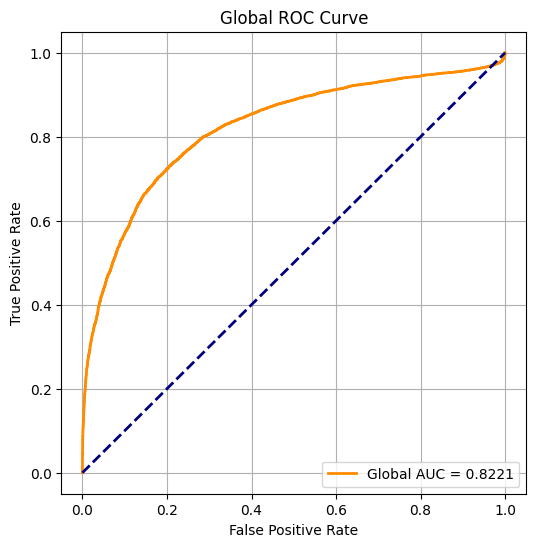

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve

# Compute global sample-level AUC
global_auc = roc_auc_score(global_labels, global_probs[:, 1])
print(f"\nGlobal Sample-Level AUC: {global_auc:.4f}")

#plot ROC curve
fpr, tpr, _ = roc_curve(global_labels, global_probs[:, 1])
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"Global AUC = {global_auc:.4f}")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Global ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()



In [11]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, roc_curve
from statistics import mode, StatisticsError
import matplotlib.pyplot as plt

seeds = [0, 1, 2 ,3, 4 , 5 , 6 ,7, 8, 9]  # Example seeds for reproducibility

all_acc_final   = []
all_f1_final    = []
all_conf_final  = []
global_probs_final  = []
global_labels_final = []
best_thresholds_final = []

set_seed(0)
#for seed in seeds:
#    set_seed(seed)  # reproducibility

# model hyperparameters (unchanged)
input_dim_pte  = 180
hidden_dim_pte = 512
num_layers_pte = 2
num_heads_pte  = 5
output_dim_pte = 128
dropout_pte    = 0.4

input_dim_psd  = 5
hidden_dim_psd = 512
num_layers_psd = 2
num_heads_psd  = 5
output_dim_psd = 128
dropout_psd    = 0.4

cross_d_model   = 128
cross_num_heads = 8



# get stratified folds
all_folds  = load_data_stratified_kfold(
    pte_directory="features",
    DE_directory="DE_features_single_window",
    batch_size=32,
    selected_classes=["ctrl","ftd"],
    selected_channels=['O1','O2','T4','T3','F7','F8'],
    n_splits=10,
    n_repetitions=30,
)


for folds in all_folds:

    # accumulators
    all_acc   = []
    all_f1    = []
    all_conf  = []
    global_probs  = []
    global_labels = []
    best_thresholds = []


    for fold_idx, (train_loader, val_loader) in enumerate(folds, 1):
        print(f"\n===== Fold {fold_idx}/{len(folds)} =====")

        # 1) model init
        model = FinalModel(
            pte_input_dim=input_dim_pte,
            pte_hidden_dim=hidden_dim_pte,
            pte_num_layers=num_layers_pte,
            pte_num_heads=num_heads_pte,
            pte_output_dim=output_dim_pte,
            pte_dropout=dropout_pte,
            psd_input_dim=input_dim_psd,
            psd_hidden_dim=hidden_dim_psd,
            psd_num_layers=num_layers_psd,
            psd_num_heads=num_heads_psd,
            psd_output_dim=output_dim_psd,
            psd_dropout=dropout_psd,
            cross_d_model=cross_d_model,
            cross_num_heads=cross_num_heads
        )

        device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        # 2) loss & optimizer
        # class_weights = torch.tensor([1.0, 0.8], device=device)
        #balance the classes weights
        # from sklearn.utils.class_weight import compute_class_weight
        # labels = []
        # for _, _, y, _ in train_loader:
        #     labels.extend(y.numpy())
        # labels = np.array(labels)
        # class_weights = compute_class_weight(
        #     class_weight='balanced',
        #     classes=np.unique(labels),
        #     y=labels
        # )
        # class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
        # class_weights = torch.tensor([1.0, 0.7], device=device)
        # print(f"Class weights: {class_weights}")
        criterion_label = nn.CrossEntropyLoss()
        # criterion_label = FocalLoss(gamma=2, alpha=class_weights, reduction='mean', task_type='multi-class', num_classes=2)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
        # 3) train
        num_epochs = 100
        label_acc_history, _ = train_model(
            model=model,
            source_dataloader=train_loader,
            target_dataloader=val_loader,
            criterion_label=criterion_label,
            criterion_domain=criterion_label,
            optimizer=optimizer,
            num_epochs=num_epochs,
            device=device,
            scheduler=None,
        )
        print(f"Final training label acc: {label_acc_history[-1]:.2f}%")

        # 4) threshold tuning on train set
        thresholds_to_try = [0.2,0.3,0.4,0.5]
        best_thr = tune_threshold_on_source(
            model=model,
            source_dataloader=train_loader,
            device=device,
            thresholds=thresholds_to_try,
            num_classes=2
        )
        best_thresholds.append(best_thr)

        # 5) test on validation set
        test_loss, test_acc, test_f1, conf_mat, preds, labels, alz_ratio, true_label = test_model(
            model=model,
            test_dataloader=val_loader,
            criterion_label=criterion_label,
            device=device,
            num_classes=2,
            alz_threshold=best_thr
        )

        print(f"Final validation loss: {test_loss:.4f}")
        print(f"Final validation acc: {test_acc:.2f}%")
        print(f"Final validation f1: {test_f1:.2f}%")

        # 6) record metrics
        all_acc.append(test_acc)
        all_f1.append(test_f1)
        all_conf.append(conf_mat)
        global_probs.append(preds)
        global_labels.append(labels)
        best_thresholds.append(best_thr)

    # ────────── 7) Final results ─────────────────────────────
    all_acc_final.append(all_acc)
    all_f1_final.append(all_f1)
    all_conf_final.append(all_conf)
    global_probs_final.append(global_probs)
    global_labels_final.append(global_labels)
    best_thresholds_final.append(best_thresholds)

    print(f"\n=== Cross‐Val Results ===")
    print(f"Accuracies per fold: {all_acc}")
    print(f"Mean acc: {np.mean(all_acc):.2f}%, Std: {np.std(all_acc):.2f}%")
    print(f"Mean f1: {np.mean(all_f1):.2f}%, Std: {np.std(all_f1):.2f}%")

final_results = {
"all_acc": all_acc_final,
"all_f1": all_f1_final,
"all_conf": all_conf_final,
"global_probs": global_probs_final,
"global_labels": global_labels_final,
"best_thresholds": best_thresholds_final
}

np.savez(
    "final_results_cn_ftd_dtca.npz",
    final_results=final_results
)

Seed set to: 0
[rep 00] SMOTE added 87 synthetic samples
[rep 00] SMOTE added 83 synthetic samples
[rep 00] SMOTE added 71 synthetic samples
[rep 00] SMOTE added 71 synthetic samples
[rep 00] SMOTE added 91 synthetic samples
[rep 00] SMOTE added 90 synthetic samples
[rep 00] SMOTE added 103 synthetic samples
[rep 00] SMOTE added 102 synthetic samples
[rep 00] SMOTE added 95 synthetic samples
[rep 00] SMOTE added 98 synthetic samples
[rep 01] SMOTE added 88 synthetic samples
[rep 01] SMOTE added 82 synthetic samples
[rep 01] SMOTE added 70 synthetic samples
[rep 01] SMOTE added 67 synthetic samples
[rep 01] SMOTE added 94 synthetic samples
[rep 01] SMOTE added 97 synthetic samples
[rep 01] SMOTE added 102 synthetic samples
[rep 01] SMOTE added 99 synthetic samples
[rep 01] SMOTE added 96 synthetic samples
[rep 01] SMOTE added 96 synthetic samples
[rep 02] SMOTE added 86 synthetic samples
[rep 02] SMOTE added 83 synthetic samples
[rep 02] SMOTE added 68 synthetic samples
[rep 02] SMOTE a

/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.09%
[Threshold 0.2] -> F1=0.7824 | Acc=0.7838
[Threshold 0.3] -> F1=0.8649 | Acc=0.8649
[Threshold 0.4] -> F1=0.9187 | Acc=0.9189
[Threshold 0.5] -> F1=0.9456 | Acc=0.9459

[Best Threshold] = 0.5 with F1=0.9456
Final validation loss: 0.6138
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.26%
[Threshold 0.2] -> F1=0.6947 | Acc=0.7027
[Threshold 0.3] -> F1=0.8377 | Acc=0.8378
[Threshold 0.4] -> F1=0.8918 | Acc=0.8919
[Threshold 0.5] -> F1=0.9456 | Acc=0.9459

[Best Threshold] = 0.5 with F1=0.9456
Final validation loss: 1.6000
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.25%
[Threshold 0.2] -> F1=0.8417 | Acc=0.8421
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.9197 | Acc=0.9211
[Threshold 0.5] -> F1=0.9197 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9197
Final validation loss: 0.5076
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.96%
[Threshold 0.2] -> F1=0.7871 | Acc=0.7895
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.8947 | Acc=0.8947
[Threshold 0.5] -> F1=0.9472 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9472
Final validation loss: 0.6376
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.72%
[Threshold 0.2] -> F1=0.7889 | Acc=0.7895
[Threshold 0.3] -> F1=0.8157 | Acc=0.8158
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.5 with F1=0.9732
Final validation loss: 1.2177
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 77.41%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9197 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9468
Final validation loss: 0.3184
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.71%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9468
Final validation loss: 0.8636
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 90.10%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.9206 | Acc=0.9211
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 3.3990
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.16%
[Threshold 0.2] -> F1=0.6761 | Acc=0.6842
[Threshold 0.3] -> F1=0.7617 | Acc=0.7632
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 0.4354
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.62%
[Threshold 0.2] -> F1=0.7339 | Acc=0.7368
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 0.8248
Final validation acc: 75.00%
Final validation f1: 0.73%

=== Cross‐Val Results ===
Accuracies per fold: [100.0, 60.0, 75.0, 75.0, 75.0, 100.0, 75.0, 50.0, 100.0, 75.0]
Mean acc: 78.50%, Std: 16.13%
Mean f1: 0.76%, Std: 0.20%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.54%
[Threshold 0.2] -> F1=0.8103 | Acc=0.8108
[Threshold 0.3] -> F1=0.8103 | Acc=0.8108
[Threshold 0.4] -> F1=0.8918 | Acc=0.8919
[Threshold 0.5] -> F1=0.9187 | Acc=0.9189

[Best Threshold] = 0.5 with F1=0.9187
Final validation loss: 0.7514
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.03%
[Threshold 0.2] -> F1=0.7539 | Acc=0.7568
[Threshold 0.3] -> F1=0.7539 | Acc=0.7568
[Threshold 0.4] -> F1=0.8103 | Acc=0.8108
[Threshold 0.5] -> F1=0.8918 | Acc=0.8919

[Best Threshold] = 0.5 with F1=0.8918
Final validation loss: 0.7517
Final validation acc: 40.00%
Final validation f1: 0.40%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 77.24%
[Threshold 0.2] -> F1=0.7301 | Acc=0.7368
[Threshold 0.3] -> F1=0.8146 | Acc=0.8158
[Threshold 0.4] -> F1=0.9735 | Acc=0.9737
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9735
Final validation loss: 0.3531
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.45%
[Threshold 0.2] -> F1=0.6696 | Acc=0.6842
[Threshold 0.3] -> F1=0.7301 | Acc=0.7368
[Threshold 0.4] -> F1=0.7871 | Acc=0.7895
[Threshold 0.5] -> F1=0.8683 | Acc=0.8684

[Best Threshold] = 0.5 with F1=0.8683
Final validation loss: 1.1778
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 77.34%
[Threshold 0.2] -> F1=0.7054 | Acc=0.7105
[Threshold 0.3] -> F1=0.7889 | Acc=0.7895
[Threshold 0.4] -> F1=0.8421 | Acc=0.8421
[Threshold 0.5] -> F1=0.8683 | Acc=0.8684

[Best Threshold] = 0.5 with F1=0.8683
Final validation loss: 2.3702
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 77.57%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.8676 | Acc=0.8684

[Best Threshold] = 0.4 with F1=0.8683
Final validation loss: 0.4803
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.16%
[Threshold 0.2] -> F1=0.7889 | Acc=0.7895
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.5 with F1=0.9732
Final validation loss: 0.6895
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.11%
[Threshold 0.2] -> F1=0.7889 | Acc=0.7895
[Threshold 0.3] -> F1=0.8676 | Acc=0.8684
[Threshold 0.4] -> F1=0.8936 | Acc=0.8947
[Threshold 0.5] -> F1=0.9460 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9460
Final validation loss: 1.3758
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.62%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9206
Final validation loss: 2.7306
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.72%
[Threshold 0.2] -> F1=0.7889 | Acc=0.7895
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9468
Final validation loss: 1.1971
Final validation acc: 50.00%
Final validation f1: 0.33%

=== Cross‐Val Results ===
Accuracies per fold: [60.0, 40.0, 75.0, 50.0, 25.0, 75.0, 75.0, 25.0, 50.0, 50.0]
Mean acc: 52.50%, Std: 18.06%
Mean f1: 0.49%, Std: 0.20%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.77%
[Threshold 0.2] -> F1=0.8649 | Acc=0.8649
[Threshold 0.3] -> F1=0.9187 | Acc=0.9189
[Threshold 0.4] -> F1=0.9456 | Acc=0.9459
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.5 with F1=1.0000
Final validation loss: 2.4007
Final validation acc: 40.00%
Final validation f1: 0.29%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.66%
[Threshold 0.2] -> F1=0.8377 | Acc=0.8378
[Threshold 0.3] -> F1=0.8377 | Acc=0.8378
[Threshold 0.4] -> F1=0.9456 | Acc=0.9459
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.5 with F1=1.0000
Final validation loss: 1.2594
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.82%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.9472 | Acc=0.9474
[Threshold 0.4] -> F1=0.9735 | Acc=0.9737
[Threshold 0.5] -> F1=0.9735 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9735
Final validation loss: 0.8989
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.11%
[Threshold 0.2] -> F1=0.8947 | Acc=0.8947
[Threshold 0.3] -> F1=0.9735 | Acc=0.9737
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 0.9617
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.90%
[Threshold 0.2] -> F1=0.7889 | Acc=0.7895
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.5 with F1=0.9732
Final validation loss: 0.6447
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.97%
[Threshold 0.2] -> F1=0.7054 | Acc=0.7105
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.8944 | Acc=0.8947

[Best Threshold] = 0.4 with F1=0.8944
Final validation loss: 0.2090
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.36%
[Threshold 0.2] -> F1=0.7054 | Acc=0.7105
[Threshold 0.3] -> F1=0.7339 | Acc=0.7368
[Threshold 0.4] -> F1=0.8157 | Acc=0.8158
[Threshold 0.5] -> F1=0.8944 | Acc=0.8947

[Best Threshold] = 0.5 with F1=0.8944
Final validation loss: 0.9834
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.84%
[Threshold 0.2] -> F1=0.7339 | Acc=0.7368
[Threshold 0.3] -> F1=0.8157 | Acc=0.8158
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.5 with F1=0.9732
Final validation loss: 0.9456
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.38%
[Threshold 0.2] -> F1=0.7054 | Acc=0.7105
[Threshold 0.3] -> F1=0.7339 | Acc=0.7368
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9206
Final validation loss: 0.5603
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.69%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.8936 | Acc=0.8947
[Threshold 0.4] -> F1=0.9460 | Acc=0.9474
[Threshold 0.5] -> F1=0.9460 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9460
Final validation loss: 0.5419
Final validation acc: 75.00%
Final validation f1: 0.73%

=== Cross‐Val Results ===
Accuracies per fold: [40.0, 60.0, 50.0, 50.0, 100.0, 100.0, 75.0, 50.0, 100.0, 75.0]
Mean acc: 70.00%, Std: 22.25%
Mean f1: 0.67%, Std: 0.26%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.09%
[Threshold 0.2] -> F1=0.8103 | Acc=0.8108
[Threshold 0.3] -> F1=0.8103 | Acc=0.8108
[Threshold 0.4] -> F1=0.8918 | Acc=0.8919
[Threshold 0.5] -> F1=0.9187 | Acc=0.9189

[Best Threshold] = 0.5 with F1=0.9187
Final validation loss: 0.4246
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 76.16%
[Threshold 0.2] -> F1=0.7824 | Acc=0.7838
[Threshold 0.3] -> F1=0.8377 | Acc=0.8378
[Threshold 0.4] -> F1=0.8912 | Acc=0.8919
[Threshold 0.5] -> F1=0.8912 | Acc=0.8919

[Best Threshold] = 0.4 with F1=0.8912
Final validation loss: 0.2832
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.36%
[Threshold 0.2] -> F1=0.7301 | Acc=0.7368
[Threshold 0.3] -> F1=0.8146 | Acc=0.8158
[Threshold 0.4] -> F1=0.8947 | Acc=0.8947
[Threshold 0.5] -> F1=0.9472 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9472
Final validation loss: 1.0026
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.08%
[Threshold 0.2] -> F1=0.7590 | Acc=0.7632
[Threshold 0.3] -> F1=0.8146 | Acc=0.8158
[Threshold 0.4] -> F1=0.8417 | Acc=0.8421
[Threshold 0.5] -> F1=0.8683 | Acc=0.8684

[Best Threshold] = 0.5 with F1=0.8683
Final validation loss: 2.7294
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.62%
[Threshold 0.2] -> F1=0.8421 | Acc=0.8421
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=0.9728 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9732
Final validation loss: 1.1738
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.77%
[Threshold 0.2] -> F1=0.8944 | Acc=0.8947
[Threshold 0.3] -> F1=0.9206 | Acc=0.9211
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=0.9460 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9732
Final validation loss: 0.5433
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.54%
[Threshold 0.2] -> F1=0.7889 | Acc=0.7895
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 2.0311
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.22%
[Threshold 0.2] -> F1=1.0000 | Acc=1.0000
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=0.9728 | Acc=0.9737
[Threshold 0.5] -> F1=0.9449 | Acc=0.9474

[Best Threshold] = 0.2 with F1=1.0000
Final validation loss: 1.5641
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.39%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.9468 | Acc=0.9474
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.3 with F1=0.9468
Final validation loss: 0.8962
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.55%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9468
Final validation loss: 0.8467
Final validation acc: 75.00%
Final validation f1: 0.73%

=== Cross‐Val Results ===
Accuracies per fold: [80.0, 100.0, 50.0, 25.0, 25.0, 100.0, 75.0, 50.0, 75.0, 75.0]
Mean acc: 65.50%, Std: 25.73%
Mean f1: 0.62%, Std: 0.28%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.15%
[Threshold 0.2] -> F1=0.7539 | Acc=0.7568
[Threshold 0.3] -> F1=0.8377 | Acc=0.8378
[Threshold 0.4] -> F1=0.9187 | Acc=0.9189
[Threshold 0.5] -> F1=0.9727 | Acc=0.9730

[Best Threshold] = 0.5 with F1=0.9727
Final validation loss: 2.6746
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 76.80%
[Threshold 0.2] -> F1=0.7824 | Acc=0.7838
[Threshold 0.3] -> F1=0.8377 | Acc=0.8378
[Threshold 0.4] -> F1=0.9187 | Acc=0.9189
[Threshold 0.5] -> F1=0.9187 | Acc=0.9189

[Best Threshold] = 0.4 with F1=0.9187
Final validation loss: 0.6064
Final validation acc: 40.00%
Final validation f1: 0.40%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.26%
[Threshold 0.2] -> F1=0.6696 | Acc=0.6842
[Threshold 0.3] -> F1=0.7301 | Acc=0.7368
[Threshold 0.4] -> F1=0.7301 | Acc=0.7368
[Threshold 0.5] -> F1=0.8417 | Acc=0.8421

[Best Threshold] = 0.5 with F1=0.8417
Final validation loss: 0.9525
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.54%
[Threshold 0.2] -> F1=0.8947 | Acc=0.8947
[Threshold 0.3] -> F1=0.9468 | Acc=0.9474
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.3 with F1=0.9468
Final validation loss: 0.8588
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.30%
[Threshold 0.2] -> F1=0.9206 | Acc=0.9211
[Threshold 0.3] -> F1=0.9206 | Acc=0.9211
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9197 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9468
Final validation loss: 0.8025
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.44%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.5 with F1=0.9732
Final validation loss: 3.2408
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.51%
[Threshold 0.2] -> F1=0.8421 | Acc=0.8421
[Threshold 0.3] -> F1=0.9468 | Acc=0.9474
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9732
Final validation loss: 0.5834
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.95%
[Threshold 0.2] -> F1=0.9206 | Acc=0.9211
[Threshold 0.3] -> F1=0.8936 | Acc=0.8947
[Threshold 0.4] -> F1=0.9183 | Acc=0.9211
[Threshold 0.5] -> F1=0.8869 | Acc=0.8947

[Best Threshold] = 0.2 with F1=0.9206
Final validation loss: 1.4210
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.88%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.9206 | Acc=0.9211
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.5 with F1=1.0000
Final validation loss: 1.1923
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.03%
[Threshold 0.2] -> F1=0.6761 | Acc=0.6842
[Threshold 0.3] -> F1=0.8157 | Acc=0.8158
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.8936 | Acc=0.8947

[Best Threshold] = 0.4 with F1=0.8944
Final validation loss: 0.3469
Final validation acc: 100.00%
Final validation f1: 1.00%

=== Cross‐Val Results ===
Accuracies per fold: [80.0, 40.0, 25.0, 50.0, 50.0, 25.0, 100.0, 50.0, 50.0, 100.0]
Mean acc: 57.00%, Std: 26.00%
Mean f1: 0.52%, Std: 0.28%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.11%
[Threshold 0.2] -> F1=0.8103 | Acc=0.8108
[Threshold 0.3] -> F1=0.8649 | Acc=0.8649
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 1.1015
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.90%
[Threshold 0.2] -> F1=0.9187 | Acc=0.9189
[Threshold 0.3] -> F1=0.9727 | Acc=0.9730
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 0.7443
Final validation acc: 40.00%
Final validation f1: 0.40%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.19%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.8947 | Acc=0.8947
[Threshold 0.4] -> F1=0.9210 | Acc=0.9211
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9468
Final validation loss: 0.9649
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.11%
[Threshold 0.2] -> F1=0.8417 | Acc=0.8421
[Threshold 0.3] -> F1=0.8947 | Acc=0.8947
[Threshold 0.4] -> F1=0.9735 | Acc=0.9737
[Threshold 0.5] -> F1=0.9735 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9735
Final validation loss: 2.3937
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.45%
[Threshold 0.2] -> F1=0.8421 | Acc=0.8421
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.5 with F1=0.9732
Final validation loss: 0.8056
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.85%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.5 with F1=0.9732
Final validation loss: 1.8695
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 77.84%
[Threshold 0.2] -> F1=0.8421 | Acc=0.8421
[Threshold 0.3] -> F1=0.9468 | Acc=0.9474
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.8899 | Acc=0.8947

[Best Threshold] = 0.3 with F1=0.9468
Final validation loss: 0.2838
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.94%
[Threshold 0.2] -> F1=0.7339 | Acc=0.7368
[Threshold 0.3] -> F1=0.7617 | Acc=0.7632
[Threshold 0.4] -> F1=0.7889 | Acc=0.7895
[Threshold 0.5] -> F1=0.8157 | Acc=0.8158

[Best Threshold] = 0.5 with F1=0.8157
Final validation loss: 0.4186
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 77.24%
[Threshold 0.2] -> F1=0.7339 | Acc=0.7368
[Threshold 0.3] -> F1=0.7339 | Acc=0.7368
[Threshold 0.4] -> F1=0.8157 | Acc=0.8158
[Threshold 0.5] -> F1=0.8683 | Acc=0.8684

[Best Threshold] = 0.5 with F1=0.8683
Final validation loss: 0.4699
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.97%
[Threshold 0.2] -> F1=0.9206 | Acc=0.9211
[Threshold 0.3] -> F1=0.9197 | Acc=0.9211
[Threshold 0.4] -> F1=0.9460 | Acc=0.9474
[Threshold 0.5] -> F1=0.9183 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9460
Final validation loss: 0.9100
Final validation acc: 75.00%
Final validation f1: 0.73%

=== Cross‐Val Results ===
Accuracies per fold: [60.0, 40.0, 25.0, 50.0, 50.0, 75.0, 75.0, 100.0, 75.0, 75.0]
Mean acc: 62.50%, Std: 20.65%
Mean f1: 0.59%, Std: 0.23%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.23%
[Threshold 0.2] -> F1=0.6636 | Acc=0.6757
[Threshold 0.3] -> F1=0.7247 | Acc=0.7297
[Threshold 0.4] -> F1=0.8649 | Acc=0.8649
[Threshold 0.5] -> F1=0.9456 | Acc=0.9459

[Best Threshold] = 0.5 with F1=0.9456
Final validation loss: 1.3280
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.29%
[Threshold 0.2] -> F1=0.7539 | Acc=0.7568
[Threshold 0.3] -> F1=0.7539 | Acc=0.7568
[Threshold 0.4] -> F1=0.8103 | Acc=0.8108
[Threshold 0.5] -> F1=0.8103 | Acc=0.8108

[Best Threshold] = 0.4 with F1=0.8103
Final validation loss: 2.5064
Final validation acc: 40.00%
Final validation f1: 0.40%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.44%
[Threshold 0.2] -> F1=0.7004 | Acc=0.7105
[Threshold 0.3] -> F1=0.7590 | Acc=0.7632
[Threshold 0.4] -> F1=0.8417 | Acc=0.8421
[Threshold 0.5] -> F1=0.8947 | Acc=0.8947

[Best Threshold] = 0.5 with F1=0.8947
Final validation loss: 0.8687
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.69%
[Threshold 0.2] -> F1=0.7301 | Acc=0.7368
[Threshold 0.3] -> F1=0.7871 | Acc=0.7895
[Threshold 0.4] -> F1=0.8417 | Acc=0.8421
[Threshold 0.5] -> F1=0.9210 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9210
Final validation loss: 0.5682
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.39%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9206
Final validation loss: 0.7864
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.16%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.8661 | Acc=0.8684
[Threshold 0.4] -> F1=0.8920 | Acc=0.8947
[Threshold 0.5] -> F1=0.8920 | Acc=0.8947

[Best Threshold] = 0.4 with F1=0.8920
Final validation loss: 0.9387
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.55%
[Threshold 0.2] -> F1=0.7339 | Acc=0.7368
[Threshold 0.3] -> F1=0.7889 | Acc=0.7895
[Threshold 0.4] -> F1=0.7889 | Acc=0.7895
[Threshold 0.5] -> F1=0.8421 | Acc=0.8421

[Best Threshold] = 0.5 with F1=0.8421
Final validation loss: 0.5726
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.95%
[Threshold 0.2] -> F1=0.6761 | Acc=0.6842
[Threshold 0.3] -> F1=0.7339 | Acc=0.7368
[Threshold 0.4] -> F1=0.8157 | Acc=0.8158
[Threshold 0.5] -> F1=0.8683 | Acc=0.8684

[Best Threshold] = 0.5 with F1=0.8683
Final validation loss: 0.7584
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.51%
[Threshold 0.2] -> F1=0.8421 | Acc=0.8421
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 2.0378
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.79%
[Threshold 0.2] -> F1=0.7339 | Acc=0.7368
[Threshold 0.3] -> F1=0.8157 | Acc=0.8158
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 0.5126
Final validation acc: 75.00%
Final validation f1: 0.73%

=== Cross‐Val Results ===
Accuracies per fold: [60.0, 40.0, 75.0, 75.0, 25.0, 50.0, 75.0, 50.0, 75.0, 75.0]
Mean acc: 60.00%, Std: 17.18%
Mean f1: 0.59%, Std: 0.18%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.29%
[Threshold 0.2] -> F1=0.7539 | Acc=0.7568
[Threshold 0.3] -> F1=0.8103 | Acc=0.8108
[Threshold 0.4] -> F1=0.8918 | Acc=0.8919
[Threshold 0.5] -> F1=0.9187 | Acc=0.9189

[Best Threshold] = 0.5 with F1=0.9187
Final validation loss: 0.2988
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.12%
[Threshold 0.2] -> F1=0.5978 | Acc=0.6216
[Threshold 0.3] -> F1=0.8103 | Acc=0.8108
[Threshold 0.4] -> F1=0.8918 | Acc=0.8919
[Threshold 0.5] -> F1=0.9187 | Acc=0.9189

[Best Threshold] = 0.5 with F1=0.9187
Final validation loss: 0.8858
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.87%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.8947 | Acc=0.8947
[Threshold 0.4] -> F1=0.9735 | Acc=0.9737
[Threshold 0.5] -> F1=0.9735 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9735
Final validation loss: 1.4346
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.64%
[Threshold 0.2] -> F1=0.7590 | Acc=0.7632
[Threshold 0.3] -> F1=0.7871 | Acc=0.7895
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.8947 | Acc=0.8947

[Best Threshold] = 0.5 with F1=0.8947
Final validation loss: 2.3017
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.71%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.8157 | Acc=0.8158
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9468
Final validation loss: 2.6214
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.16%
[Threshold 0.2] -> F1=0.7339 | Acc=0.7368
[Threshold 0.3] -> F1=0.7889 | Acc=0.7895
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.5 with F1=0.9732
Final validation loss: 1.2190
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.11%
[Threshold 0.2] -> F1=0.6145 | Acc=0.6316
[Threshold 0.3] -> F1=0.7339 | Acc=0.7368
[Threshold 0.4] -> F1=0.8157 | Acc=0.8158
[Threshold 0.5] -> F1=0.8421 | Acc=0.8421

[Best Threshold] = 0.5 with F1=0.8421
Final validation loss: 0.2930
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.39%
[Threshold 0.2] -> F1=0.6145 | Acc=0.6316
[Threshold 0.3] -> F1=0.6459 | Acc=0.6579
[Threshold 0.4] -> F1=0.6761 | Acc=0.6842
[Threshold 0.5] -> F1=0.7339 | Acc=0.7368

[Best Threshold] = 0.5 with F1=0.7339
Final validation loss: 0.8361
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.85%
[Threshold 0.2] -> F1=0.6761 | Acc=0.6842
[Threshold 0.3] -> F1=0.7889 | Acc=0.7895
[Threshold 0.4] -> F1=0.8421 | Acc=0.8421
[Threshold 0.5] -> F1=0.8944 | Acc=0.8947

[Best Threshold] = 0.5 with F1=0.8944
Final validation loss: 0.7738
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.08%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.8157 | Acc=0.8158
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 0.3499
Final validation acc: 100.00%
Final validation f1: 1.00%

=== Cross‐Val Results ===
Accuracies per fold: [100.0, 60.0, 25.0, 25.0, 75.0, 50.0, 100.0, 50.0, 75.0, 100.0]
Mean acc: 66.00%, Std: 27.46%
Mean f1: 0.63%, Std: 0.30%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.96%
[Threshold 0.2] -> F1=0.8649 | Acc=0.8649
[Threshold 0.3] -> F1=0.9187 | Acc=0.9189
[Threshold 0.4] -> F1=0.9727 | Acc=0.9730
[Threshold 0.5] -> F1=0.9727 | Acc=0.9730

[Best Threshold] = 0.4 with F1=0.9727
Final validation loss: 2.9327
Final validation acc: 40.00%
Final validation f1: 0.29%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.41%
[Threshold 0.2] -> F1=0.7824 | Acc=0.7838
[Threshold 0.3] -> F1=0.8103 | Acc=0.8108
[Threshold 0.4] -> F1=0.8649 | Acc=0.8649
[Threshold 0.5] -> F1=0.9187 | Acc=0.9189

[Best Threshold] = 0.5 with F1=0.9187
Final validation loss: 0.7151
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.14%
[Threshold 0.2] -> F1=0.7590 | Acc=0.7632
[Threshold 0.3] -> F1=0.8146 | Acc=0.8158
[Threshold 0.4] -> F1=0.9210 | Acc=0.9211
[Threshold 0.5] -> F1=0.9210 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9210
Final validation loss: 1.7020
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 77.24%
[Threshold 0.2] -> F1=0.6696 | Acc=0.6842
[Threshold 0.3] -> F1=0.7004 | Acc=0.7105
[Threshold 0.4] -> F1=0.7004 | Acc=0.7105
[Threshold 0.5] -> F1=0.7301 | Acc=0.7368

[Best Threshold] = 0.5 with F1=0.7301
Final validation loss: 0.4866
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.51%
[Threshold 0.2] -> F1=0.6459 | Acc=0.6579
[Threshold 0.3] -> F1=0.7339 | Acc=0.7368
[Threshold 0.4] -> F1=0.8157 | Acc=0.8158
[Threshold 0.5] -> F1=0.8157 | Acc=0.8158

[Best Threshold] = 0.4 with F1=0.8157
Final validation loss: 1.8330
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.79%
[Threshold 0.2] -> F1=0.7889 | Acc=0.7895
[Threshold 0.3] -> F1=0.8157 | Acc=0.8158
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9468
Final validation loss: 0.5591
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 76.96%
[Threshold 0.2] -> F1=0.6459 | Acc=0.6579
[Threshold 0.3] -> F1=0.6459 | Acc=0.6579
[Threshold 0.4] -> F1=0.7054 | Acc=0.7105
[Threshold 0.5] -> F1=0.7617 | Acc=0.7632

[Best Threshold] = 0.5 with F1=0.7617
Final validation loss: 0.7321
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.16%
[Threshold 0.2] -> F1=0.6459 | Acc=0.6579
[Threshold 0.3] -> F1=0.7617 | Acc=0.7632
[Threshold 0.4] -> F1=0.7617 | Acc=0.7632
[Threshold 0.5] -> F1=0.8421 | Acc=0.8421

[Best Threshold] = 0.5 with F1=0.8421
Final validation loss: 1.1908
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.68%
[Threshold 0.2] -> F1=0.8421 | Acc=0.8421
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9732
Final validation loss: 0.8298
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.74%
[Threshold 0.2] -> F1=0.7889 | Acc=0.7895
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9206
Final validation loss: 0.3646
Final validation acc: 75.00%
Final validation f1: 0.73%

=== Cross‐Val Results ===
Accuracies per fold: [40.0, 60.0, 50.0, 75.0, 50.0, 100.0, 50.0, 25.0, 100.0, 75.0]
Mean acc: 62.50%, Std: 23.48%
Mean f1: 0.59%, Std: 0.27%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 77.14%
[Threshold 0.2] -> F1=0.7824 | Acc=0.7838
[Threshold 0.3] -> F1=0.8649 | Acc=0.8649
[Threshold 0.4] -> F1=0.9187 | Acc=0.9189
[Threshold 0.5] -> F1=0.9456 | Acc=0.9459

[Best Threshold] = 0.5 with F1=0.9456
Final validation loss: 0.7174
Final validation acc: 40.00%
Final validation f1: 0.40%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 75.18%
[Threshold 0.2] -> F1=0.7539 | Acc=0.7568
[Threshold 0.3] -> F1=0.7824 | Acc=0.7838
[Threshold 0.4] -> F1=0.9187 | Acc=0.9189
[Threshold 0.5] -> F1=0.8912 | Acc=0.8919

[Best Threshold] = 0.4 with F1=0.9187
Final validation loss: 0.5611
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.64%
[Threshold 0.2] -> F1=0.6376 | Acc=0.6579
[Threshold 0.3] -> F1=0.6696 | Acc=0.6842
[Threshold 0.4] -> F1=0.6696 | Acc=0.6842
[Threshold 0.5] -> F1=0.7590 | Acc=0.7632

[Best Threshold] = 0.5 with F1=0.7590
Final validation loss: 0.8422
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.15%
[Threshold 0.2] -> F1=0.8947 | Acc=0.8947
[Threshold 0.3] -> F1=0.9210 | Acc=0.9211
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9732
Final validation loss: 0.6992
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.20%
[Threshold 0.2] -> F1=0.8421 | Acc=0.8421
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9468
Final validation loss: 1.9968
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 74.40%
[Threshold 0.2] -> F1=0.7339 | Acc=0.7368
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9468
Final validation loss: 0.3630
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.76%
[Threshold 0.2] -> F1=0.8421 | Acc=0.8421
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9468
Final validation loss: 1.0204
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.59%
[Threshold 0.2] -> F1=0.6761 | Acc=0.6842
[Threshold 0.3] -> F1=0.7054 | Acc=0.7105
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 2.8070
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.31%
[Threshold 0.2] -> F1=0.7630 | Acc=0.7632
[Threshold 0.3] -> F1=0.7630 | Acc=0.7632
[Threshold 0.4] -> F1=0.8157 | Acc=0.8158
[Threshold 0.5] -> F1=0.8417 | Acc=0.8421

[Best Threshold] = 0.5 with F1=0.8417
Final validation loss: 0.6232
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.94%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9732
Final validation loss: 1.1572
Final validation acc: 50.00%
Final validation f1: 0.50%

=== Cross‐Val Results ===
Accuracies per fold: [40.0, 60.0, 50.0, 75.0, 50.0, 100.0, 25.0, 50.0, 75.0, 50.0]
Mean acc: 57.50%, Std: 20.03%
Mean f1: 0.57%, Std: 0.21%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.60%
[Threshold 0.2] -> F1=0.8918 | Acc=0.8919
[Threshold 0.3] -> F1=0.9456 | Acc=0.9459
[Threshold 0.4] -> F1=0.9449 | Acc=0.9459
[Threshold 0.5] -> F1=0.9439 | Acc=0.9459

[Best Threshold] = 0.3 with F1=0.9456
Final validation loss: 0.6887
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 71.56%
[Threshold 0.2] -> F1=0.7539 | Acc=0.7568
[Threshold 0.3] -> F1=0.8276 | Acc=0.8378
[Threshold 0.4] -> F1=0.8276 | Acc=0.8378
[Threshold 0.5] -> F1=0.8276 | Acc=0.8378

[Best Threshold] = 0.3 with F1=0.8276
Final validation loss: 0.5149
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.65%
[Threshold 0.2] -> F1=0.6696 | Acc=0.6842
[Threshold 0.3] -> F1=0.7301 | Acc=0.7368
[Threshold 0.4] -> F1=0.8146 | Acc=0.8158
[Threshold 0.5] -> F1=0.8683 | Acc=0.8684

[Best Threshold] = 0.5 with F1=0.8683
Final validation loss: 0.4089
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.08%
[Threshold 0.2] -> F1=0.7301 | Acc=0.7368
[Threshold 0.3] -> F1=0.8417 | Acc=0.8421
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9206
Final validation loss: 0.7018
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 77.91%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.9197 | Acc=0.9211
[Threshold 0.5] -> F1=0.9460 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9460
Final validation loss: 0.6289
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.87%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.7889 | Acc=0.7895
[Threshold 0.4] -> F1=0.8421 | Acc=0.8421
[Threshold 0.5] -> F1=0.8683 | Acc=0.8684

[Best Threshold] = 0.5 with F1=0.8683
Final validation loss: 3.8523
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.23%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9206
Final validation loss: 1.4460
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.42%
[Threshold 0.2] -> F1=0.6761 | Acc=0.6842
[Threshold 0.3] -> F1=0.7889 | Acc=0.7895
[Threshold 0.4] -> F1=0.8157 | Acc=0.8158
[Threshold 0.5] -> F1=0.8421 | Acc=0.8421

[Best Threshold] = 0.5 with F1=0.8421
Final validation loss: 1.4101
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 76.47%
[Threshold 0.2] -> F1=0.8417 | Acc=0.8421
[Threshold 0.3] -> F1=0.9197 | Acc=0.9211
[Threshold 0.4] -> F1=0.9197 | Acc=0.9211
[Threshold 0.5] -> F1=0.8920 | Acc=0.8947

[Best Threshold] = 0.3 with F1=0.9197
Final validation loss: 0.9116
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.13%
[Threshold 0.2] -> F1=0.6459 | Acc=0.6579
[Threshold 0.3] -> F1=0.7054 | Acc=0.7105
[Threshold 0.4] -> F1=0.7889 | Acc=0.7895
[Threshold 0.5] -> F1=0.8683 | Acc=0.8684

[Best Threshold] = 0.5 with F1=0.8683
Final validation loss: 1.1756
Final validation acc: 50.00%
Final validation f1: 0.33%

=== Cross‐Val Results ===
Accuracies per fold: [60.0, 80.0, 75.0, 75.0, 75.0, 25.0, 50.0, 25.0, 50.0, 50.0]
Mean acc: 56.50%, Std: 19.24%
Mean f1: 0.51%, Std: 0.22%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.61%
[Threshold 0.2] -> F1=0.8918 | Acc=0.8919
[Threshold 0.3] -> F1=0.9727 | Acc=0.9730
[Threshold 0.4] -> F1=0.9722 | Acc=0.9730
[Threshold 0.5] -> F1=0.9722 | Acc=0.9730

[Best Threshold] = 0.3 with F1=0.9727
Final validation loss: 0.6476
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.96%
[Threshold 0.2] -> F1=0.8918 | Acc=0.8919
[Threshold 0.3] -> F1=0.9456 | Acc=0.9459
[Threshold 0.4] -> F1=0.9456 | Acc=0.9459
[Threshold 0.5] -> F1=0.9727 | Acc=0.9730

[Best Threshold] = 0.5 with F1=0.9727
Final validation loss: 1.6628
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.82%
[Threshold 0.2] -> F1=0.7590 | Acc=0.7632
[Threshold 0.3] -> F1=0.8146 | Acc=0.8158
[Threshold 0.4] -> F1=0.9472 | Acc=0.9474
[Threshold 0.5] -> F1=0.9735 | Acc=0.9737

[Best Threshold] = 0.5 with F1=0.9735
Final validation loss: 0.8661
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.87%
[Threshold 0.2] -> F1=0.8417 | Acc=0.8421
[Threshold 0.3] -> F1=0.9472 | Acc=0.9474
[Threshold 0.4] -> F1=0.9735 | Acc=0.9737
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9735
Final validation loss: 0.6942
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 77.49%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.9206 | Acc=0.9211
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9460 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9468
Final validation loss: 0.4570
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.55%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.8936 | Acc=0.8947

[Best Threshold] = 0.4 with F1=0.9206
Final validation loss: 0.6313
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.14%
[Threshold 0.2] -> F1=0.6761 | Acc=0.6842
[Threshold 0.3] -> F1=0.7054 | Acc=0.7105
[Threshold 0.4] -> F1=0.7889 | Acc=0.7895
[Threshold 0.5] -> F1=0.8157 | Acc=0.8158

[Best Threshold] = 0.5 with F1=0.8157
Final validation loss: 0.6124
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.67%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.8157 | Acc=0.8158
[Threshold 0.4] -> F1=0.8157 | Acc=0.8158
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 1.4243
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.85%
[Threshold 0.2] -> F1=0.7054 | Acc=0.7105
[Threshold 0.3] -> F1=0.7339 | Acc=0.7368
[Threshold 0.4] -> F1=0.8421 | Acc=0.8421
[Threshold 0.5] -> F1=0.8683 | Acc=0.8684

[Best Threshold] = 0.5 with F1=0.8683
Final validation loss: 1.1073
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.49%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.8157 | Acc=0.8158
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 2.0869
Final validation acc: 75.00%
Final validation f1: 0.73%

=== Cross‐Val Results ===
Accuracies per fold: [80.0, 80.0, 75.0, 50.0, 100.0, 75.0, 75.0, 25.0, 50.0, 75.0]
Mean acc: 68.50%, Std: 20.01%
Mean f1: 0.64%, Std: 0.24%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.61%
[Threshold 0.2] -> F1=0.8918 | Acc=0.8919
[Threshold 0.3] -> F1=0.9187 | Acc=0.9189
[Threshold 0.4] -> F1=0.9727 | Acc=0.9730
[Threshold 0.5] -> F1=0.9727 | Acc=0.9730

[Best Threshold] = 0.4 with F1=0.9727
Final validation loss: 0.5612
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.13%
[Threshold 0.2] -> F1=0.8918 | Acc=0.8919
[Threshold 0.3] -> F1=0.9187 | Acc=0.9189
[Threshold 0.4] -> F1=0.9727 | Acc=0.9730
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.5 with F1=1.0000
Final validation loss: 3.7256
Final validation acc: 40.00%
Final validation f1: 0.40%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.75%
[Threshold 0.2] -> F1=0.8146 | Acc=0.8158
[Threshold 0.3] -> F1=0.8947 | Acc=0.8947
[Threshold 0.4] -> F1=0.9472 | Acc=0.9474
[Threshold 0.5] -> F1=0.9472 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9472
Final validation loss: 0.7212
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.62%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.8936 | Acc=0.8947

[Best Threshold] = 0.4 with F1=0.9206
Final validation loss: 0.6303
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.22%
[Threshold 0.2] -> F1=0.7054 | Acc=0.7105
[Threshold 0.3] -> F1=0.7617 | Acc=0.7632
[Threshold 0.4] -> F1=0.8157 | Acc=0.8158
[Threshold 0.5] -> F1=0.8421 | Acc=0.8421

[Best Threshold] = 0.5 with F1=0.8421
Final validation loss: 0.4505
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.05%
[Threshold 0.2] -> F1=0.6761 | Acc=0.6842
[Threshold 0.3] -> F1=0.7339 | Acc=0.7368
[Threshold 0.4] -> F1=0.7617 | Acc=0.7632
[Threshold 0.5] -> F1=0.7617 | Acc=0.7632

[Best Threshold] = 0.4 with F1=0.7617
Final validation loss: 0.5801
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 77.65%
[Threshold 0.2] -> F1=0.8417 | Acc=0.8421
[Threshold 0.3] -> F1=0.9197 | Acc=0.9211
[Threshold 0.4] -> F1=0.9460 | Acc=0.9474
[Threshold 0.5] -> F1=0.9460 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9460
Final validation loss: 0.5426
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.07%
[Threshold 0.2] -> F1=0.6761 | Acc=0.6842
[Threshold 0.3] -> F1=0.7339 | Acc=0.7368
[Threshold 0.4] -> F1=0.8157 | Acc=0.8158
[Threshold 0.5] -> F1=0.8421 | Acc=0.8421

[Best Threshold] = 0.5 with F1=0.8421
Final validation loss: 2.3718
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 76.28%
[Threshold 0.2] -> F1=0.6145 | Acc=0.6316
[Threshold 0.3] -> F1=0.6761 | Acc=0.6842
[Threshold 0.4] -> F1=0.7339 | Acc=0.7368
[Threshold 0.5] -> F1=0.7889 | Acc=0.7895

[Best Threshold] = 0.5 with F1=0.7889
Final validation loss: 0.6085
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.88%
[Threshold 0.2] -> F1=0.7339 | Acc=0.7368
[Threshold 0.3] -> F1=0.7617 | Acc=0.7632
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 1.5787
Final validation acc: 50.00%
Final validation f1: 0.33%

=== Cross‐Val Results ===
Accuracies per fold: [80.0, 40.0, 50.0, 75.0, 100.0, 50.0, 75.0, 50.0, 50.0, 50.0]
Mean acc: 62.00%, Std: 18.19%
Mean f1: 0.57%, Std: 0.22%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.39%
[Threshold 0.2] -> F1=0.7539 | Acc=0.7568
[Threshold 0.3] -> F1=0.8918 | Acc=0.8919
[Threshold 0.4] -> F1=0.9727 | Acc=0.9730
[Threshold 0.5] -> F1=0.9727 | Acc=0.9730

[Best Threshold] = 0.4 with F1=0.9727
Final validation loss: 1.6711
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.18%
[Threshold 0.2] -> F1=0.9456 | Acc=0.9459
[Threshold 0.3] -> F1=0.8899 | Acc=0.8919
[Threshold 0.4] -> F1=0.8851 | Acc=0.8919
[Threshold 0.5] -> F1=0.8542 | Acc=0.8649

[Best Threshold] = 0.2 with F1=0.9456
Final validation loss: 0.6415
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.51%
[Threshold 0.2] -> F1=0.8944 | Acc=0.8947
[Threshold 0.3] -> F1=0.9468 | Acc=0.9474
[Threshold 0.4] -> F1=0.9460 | Acc=0.9474
[Threshold 0.5] -> F1=0.9183 | Acc=0.9211

[Best Threshold] = 0.3 with F1=0.9468
Final validation loss: 0.9977
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.07%
[Threshold 0.2] -> F1=0.7004 | Acc=0.7105
[Threshold 0.3] -> F1=0.7590 | Acc=0.7632
[Threshold 0.4] -> F1=0.8146 | Acc=0.8158
[Threshold 0.5] -> F1=0.8683 | Acc=0.8684

[Best Threshold] = 0.5 with F1=0.8683
Final validation loss: 0.6838
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.79%
[Threshold 0.2] -> F1=0.6145 | Acc=0.6316
[Threshold 0.3] -> F1=0.6761 | Acc=0.6842
[Threshold 0.4] -> F1=0.7617 | Acc=0.7632
[Threshold 0.5] -> F1=0.8157 | Acc=0.8158

[Best Threshold] = 0.5 with F1=0.8157
Final validation loss: 2.1342
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.74%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.7617 | Acc=0.7632
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 0.4556
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.16%
[Threshold 0.2] -> F1=0.9206 | Acc=0.9211
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=0.9728 | Acc=0.9737
[Threshold 0.5] -> F1=0.9728 | Acc=0.9737

[Best Threshold] = 0.3 with F1=1.0000
Final validation loss: 1.8970
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.24%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.8944 | Acc=0.8947

[Best Threshold] = 0.5 with F1=0.8944
Final validation loss: 0.7041
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.01%
[Threshold 0.2] -> F1=0.9732 | Acc=0.9737
[Threshold 0.3] -> F1=0.9732 | Acc=0.9737
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=0.9460 | Acc=0.9474

[Best Threshold] = 0.2 with F1=0.9732
Final validation loss: 2.6955
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.69%
[Threshold 0.2] -> F1=0.6459 | Acc=0.6579
[Threshold 0.3] -> F1=0.7339 | Acc=0.7368
[Threshold 0.4] -> F1=0.7617 | Acc=0.7632
[Threshold 0.5] -> F1=0.8157 | Acc=0.8158

[Best Threshold] = 0.5 with F1=0.8157
Final validation loss: 0.4995
Final validation acc: 100.00%
Final validation f1: 1.00%

=== Cross‐Val Results ===
Accuracies per fold: [60.0, 80.0, 25.0, 75.0, 50.0, 75.0, 75.0, 50.0, 25.0, 100.0]
Mean acc: 61.50%, Std: 23.03%
Mean f1: 0.58%, Std: 0.25%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.66%
[Threshold 0.2] -> F1=0.9187 | Acc=0.9189
[Threshold 0.3] -> F1=0.9456 | Acc=0.9459
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=0.9722 | Acc=0.9730

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 2.7399
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.80%
[Threshold 0.2] -> F1=0.7824 | Acc=0.7838
[Threshold 0.3] -> F1=0.8918 | Acc=0.8919
[Threshold 0.4] -> F1=0.9456 | Acc=0.9459
[Threshold 0.5] -> F1=0.9456 | Acc=0.9459

[Best Threshold] = 0.4 with F1=0.9456
Final validation loss: 0.3810
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.05%
[Threshold 0.2] -> F1=0.7590 | Acc=0.7632
[Threshold 0.3] -> F1=0.8417 | Acc=0.8421
[Threshold 0.4] -> F1=0.9210 | Acc=0.9211
[Threshold 0.5] -> F1=0.9735 | Acc=0.9737

[Best Threshold] = 0.5 with F1=0.9735
Final validation loss: 0.9968
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.71%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.9210 | Acc=0.9211
[Threshold 0.5] -> F1=0.9472 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9472
Final validation loss: 2.6427
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.19%
[Threshold 0.2] -> F1=0.7889 | Acc=0.7895
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9468
Final validation loss: 0.9385
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 77.40%
[Threshold 0.2] -> F1=0.9197 | Acc=0.9211
[Threshold 0.3] -> F1=0.9197 | Acc=0.9211
[Threshold 0.4] -> F1=0.9460 | Acc=0.9474
[Threshold 0.5] -> F1=0.9449 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9460
Final validation loss: 0.6393
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.01%
[Threshold 0.2] -> F1=0.7339 | Acc=0.7368
[Threshold 0.3] -> F1=0.7617 | Acc=0.7632
[Threshold 0.4] -> F1=0.8421 | Acc=0.8421
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 0.7601
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.74%
[Threshold 0.2] -> F1=0.7889 | Acc=0.7895
[Threshold 0.3] -> F1=0.7889 | Acc=0.7895
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9206
Final validation loss: 0.7313
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.34%
[Threshold 0.2] -> F1=0.7054 | Acc=0.7105
[Threshold 0.3] -> F1=0.8157 | Acc=0.8158
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 0.8665
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.11%
[Threshold 0.2] -> F1=0.6459 | Acc=0.6579
[Threshold 0.3] -> F1=0.7054 | Acc=0.7105
[Threshold 0.4] -> F1=0.8421 | Acc=0.8421
[Threshold 0.5] -> F1=0.8944 | Acc=0.8947

[Best Threshold] = 0.5 with F1=0.8944
Final validation loss: 0.5997
Final validation acc: 75.00%
Final validation f1: 0.73%

=== Cross‐Val Results ===
Accuracies per fold: [60.0, 100.0, 25.0, 25.0, 50.0, 75.0, 75.0, 75.0, 75.0, 75.0]
Mean acc: 63.50%, Std: 22.70%
Mean f1: 0.61%, Std: 0.24%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.60%
[Threshold 0.2] -> F1=0.7539 | Acc=0.7568
[Threshold 0.3] -> F1=0.7539 | Acc=0.7568
[Threshold 0.4] -> F1=0.8377 | Acc=0.8378
[Threshold 0.5] -> F1=0.8918 | Acc=0.8919

[Best Threshold] = 0.5 with F1=0.8918
Final validation loss: 0.5090
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.33%
[Threshold 0.2] -> F1=0.8649 | Acc=0.8649
[Threshold 0.3] -> F1=0.9727 | Acc=0.9730
[Threshold 0.4] -> F1=0.9727 | Acc=0.9730
[Threshold 0.5] -> F1=0.9727 | Acc=0.9730

[Best Threshold] = 0.3 with F1=0.9727
Final validation loss: 0.9384
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.87%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.9472 | Acc=0.9474
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 1.7106
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.61%
[Threshold 0.2] -> F1=0.5692 | Acc=0.6053
[Threshold 0.3] -> F1=0.6696 | Acc=0.6842
[Threshold 0.4] -> F1=0.7004 | Acc=0.7105
[Threshold 0.5] -> F1=0.7301 | Acc=0.7368

[Best Threshold] = 0.5 with F1=0.7301
Final validation loss: 1.0338
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.11%
[Threshold 0.2] -> F1=0.9468 | Acc=0.9474
[Threshold 0.3] -> F1=0.9468 | Acc=0.9474
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=0.9728 | Acc=0.9737

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 0.6867
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.27%
[Threshold 0.2] -> F1=0.7889 | Acc=0.7895
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9732
Final validation loss: 1.2158
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 74.39%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.8381 | Acc=0.8421
[Threshold 0.4] -> F1=0.8606 | Acc=0.8684
[Threshold 0.5] -> F1=0.8606 | Acc=0.8684

[Best Threshold] = 0.4 with F1=0.8606
Final validation loss: 0.4285
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.94%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.9206 | Acc=0.9211
[Threshold 0.4] -> F1=0.9197 | Acc=0.9211
[Threshold 0.5] -> F1=0.9460 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9460
Final validation loss: 0.8319
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.21%
[Threshold 0.2] -> F1=0.7889 | Acc=0.7895
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.5 with F1=0.9732
Final validation loss: 0.4460
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.88%
[Threshold 0.2] -> F1=0.9206 | Acc=0.9211
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.3 with F1=1.0000
Final validation loss: 4.0806
Final validation acc: 50.00%
Final validation f1: 0.33%

=== Cross‐Val Results ===
Accuracies per fold: [80.0, 60.0, 25.0, 50.0, 75.0, 75.0, 100.0, 75.0, 75.0, 50.0]
Mean acc: 66.50%, Std: 19.75%
Mean f1: 0.64%, Std: 0.22%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.05%
[Threshold 0.2] -> F1=0.7247 | Acc=0.7297
[Threshold 0.3] -> F1=0.8103 | Acc=0.8108
[Threshold 0.4] -> F1=0.8649 | Acc=0.8649
[Threshold 0.5] -> F1=0.9187 | Acc=0.9189

[Best Threshold] = 0.5 with F1=0.9187
Final validation loss: 3.2886
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.95%
[Threshold 0.2] -> F1=0.8377 | Acc=0.8378
[Threshold 0.3] -> F1=0.9456 | Acc=0.9459
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 1.3354
Final validation acc: 40.00%
Final validation f1: 0.29%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 77.06%
[Threshold 0.2] -> F1=0.7301 | Acc=0.7368
[Threshold 0.3] -> F1=0.7871 | Acc=0.7895
[Threshold 0.4] -> F1=0.8947 | Acc=0.8947
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 0.3326
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.09%
[Threshold 0.2] -> F1=0.7871 | Acc=0.7895
[Threshold 0.3] -> F1=0.7871 | Acc=0.7895
[Threshold 0.4] -> F1=0.8417 | Acc=0.8421
[Threshold 0.5] -> F1=0.8683 | Acc=0.8684

[Best Threshold] = 0.5 with F1=0.8683
Final validation loss: 0.8814
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.48%
[Threshold 0.2] -> F1=0.7339 | Acc=0.7368
[Threshold 0.3] -> F1=0.8157 | Acc=0.8158
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.8944 | Acc=0.8947

[Best Threshold] = 0.4 with F1=0.8944
Final validation loss: 0.4300
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.68%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=0.9460 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9732
Final validation loss: 0.3357
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.28%
[Threshold 0.2] -> F1=0.7889 | Acc=0.7895
[Threshold 0.3] -> F1=0.7889 | Acc=0.7895
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 1.0859
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.97%
[Threshold 0.2] -> F1=0.6145 | Acc=0.6316
[Threshold 0.3] -> F1=0.6459 | Acc=0.6579
[Threshold 0.4] -> F1=0.7617 | Acc=0.7632
[Threshold 0.5] -> F1=0.8157 | Acc=0.8158

[Best Threshold] = 0.5 with F1=0.8157
Final validation loss: 2.3559
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.38%
[Threshold 0.2] -> F1=0.7339 | Acc=0.7368
[Threshold 0.3] -> F1=0.7617 | Acc=0.7632
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.8944 | Acc=0.8947

[Best Threshold] = 0.5 with F1=0.8944
Final validation loss: 0.5962
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.36%
[Threshold 0.2] -> F1=0.9468 | Acc=0.9474
[Threshold 0.3] -> F1=0.9468 | Acc=0.9474
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9732
Final validation loss: 2.9018
Final validation acc: 25.00%
Final validation f1: 0.20%

=== Cross‐Val Results ===
Accuracies per fold: [80.0, 40.0, 100.0, 50.0, 100.0, 100.0, 50.0, 25.0, 75.0, 25.0]
Mean acc: 64.50%, Std: 28.76%
Mean f1: 0.62%, Std: 0.31%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.23%
[Threshold 0.2] -> F1=0.8918 | Acc=0.8919
[Threshold 0.3] -> F1=0.9456 | Acc=0.9459
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=0.9722 | Acc=0.9730

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 1.3255
Final validation acc: 40.00%
Final validation f1: 0.29%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.36%
[Threshold 0.2] -> F1=0.8649 | Acc=0.8649
[Threshold 0.3] -> F1=0.8918 | Acc=0.8919
[Threshold 0.4] -> F1=0.9727 | Acc=0.9730
[Threshold 0.5] -> F1=0.9727 | Acc=0.9730

[Best Threshold] = 0.4 with F1=0.9727
Final validation loss: 1.1750
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.96%
[Threshold 0.2] -> F1=0.7590 | Acc=0.7632
[Threshold 0.3] -> F1=0.8417 | Acc=0.8421
[Threshold 0.4] -> F1=0.8947 | Acc=0.8947
[Threshold 0.5] -> F1=0.9210 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9210
Final validation loss: 0.7592
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.62%
[Threshold 0.2] -> F1=0.7590 | Acc=0.7632
[Threshold 0.3] -> F1=0.8146 | Acc=0.8158
[Threshold 0.4] -> F1=0.8417 | Acc=0.8421
[Threshold 0.5] -> F1=0.8683 | Acc=0.8684

[Best Threshold] = 0.5 with F1=0.8683
Final validation loss: 0.4649
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.40%
[Threshold 0.2] -> F1=0.7339 | Acc=0.7368
[Threshold 0.3] -> F1=0.7889 | Acc=0.7895
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9206
Final validation loss: 0.9475
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.38%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.9468 | Acc=0.9474
[Threshold 0.4] -> F1=0.9197 | Acc=0.9211
[Threshold 0.5] -> F1=0.9183 | Acc=0.9211

[Best Threshold] = 0.3 with F1=0.9468
Final validation loss: 0.4522
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.47%
[Threshold 0.2] -> F1=0.8421 | Acc=0.8421
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9460 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9460
Final validation loss: 2.4408
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.48%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.9206 | Acc=0.9211
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9460 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9468
Final validation loss: 0.4887
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.86%
[Threshold 0.2] -> F1=0.5818 | Acc=0.6053
[Threshold 0.3] -> F1=0.7054 | Acc=0.7105
[Threshold 0.4] -> F1=0.7617 | Acc=0.7632
[Threshold 0.5] -> F1=0.7889 | Acc=0.7895

[Best Threshold] = 0.5 with F1=0.7889
Final validation loss: 0.6912
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.30%
[Threshold 0.2] -> F1=0.8421 | Acc=0.8421
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9468
Final validation loss: 3.5799
Final validation acc: 50.00%
Final validation f1: 0.50%

=== Cross‐Val Results ===
Accuracies per fold: [40.0, 60.0, 50.0, 100.0, 75.0, 100.0, 50.0, 100.0, 75.0, 50.0]
Mean acc: 70.00%, Std: 22.25%
Mean f1: 0.68%, Std: 0.24%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.16%
[Threshold 0.2] -> F1=0.7539 | Acc=0.7568
[Threshold 0.3] -> F1=0.8377 | Acc=0.8378
[Threshold 0.4] -> F1=0.9187 | Acc=0.9189
[Threshold 0.5] -> F1=0.9456 | Acc=0.9459

[Best Threshold] = 0.5 with F1=0.9456
Final validation loss: 0.5981
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.82%
[Threshold 0.2] -> F1=0.8918 | Acc=0.8919
[Threshold 0.3] -> F1=0.9727 | Acc=0.9730
[Threshold 0.4] -> F1=0.9727 | Acc=0.9730
[Threshold 0.5] -> F1=0.9727 | Acc=0.9730

[Best Threshold] = 0.3 with F1=0.9727
Final validation loss: 1.1948
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.89%
[Threshold 0.2] -> F1=0.7871 | Acc=0.7895
[Threshold 0.3] -> F1=0.8947 | Acc=0.8947
[Threshold 0.4] -> F1=0.9210 | Acc=0.9211
[Threshold 0.5] -> F1=0.9472 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9472
Final validation loss: 0.5088
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.27%
[Threshold 0.2] -> F1=0.8146 | Acc=0.8158
[Threshold 0.3] -> F1=0.8947 | Acc=0.8947
[Threshold 0.4] -> F1=0.9472 | Acc=0.9474
[Threshold 0.5] -> F1=0.9472 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9472
Final validation loss: 1.1341
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.24%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 0.4432
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.54%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.8157 | Acc=0.8158
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.5 with F1=0.9732
Final validation loss: 2.0376
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.57%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.7889 | Acc=0.7895
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9468
Final validation loss: 1.0946
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.16%
[Threshold 0.2] -> F1=0.6761 | Acc=0.6842
[Threshold 0.3] -> F1=0.7339 | Acc=0.7368
[Threshold 0.4] -> F1=0.7617 | Acc=0.7632
[Threshold 0.5] -> F1=0.8421 | Acc=0.8421

[Best Threshold] = 0.5 with F1=0.8421
Final validation loss: 0.5397
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.59%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.8157 | Acc=0.8158
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.8683 | Acc=0.8684

[Best Threshold] = 0.4 with F1=0.8683
Final validation loss: 2.2881
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.08%
[Threshold 0.2] -> F1=0.7339 | Acc=0.7368
[Threshold 0.3] -> F1=0.7889 | Acc=0.7895
[Threshold 0.4] -> F1=0.8421 | Acc=0.8421
[Threshold 0.5] -> F1=0.8683 | Acc=0.8684

[Best Threshold] = 0.5 with F1=0.8683
Final validation loss: 1.0953
Final validation acc: 50.00%
Final validation f1: 0.33%

=== Cross‐Val Results ===
Accuracies per fold: [100.0, 80.0, 75.0, 25.0, 100.0, 75.0, 50.0, 75.0, 50.0, 50.0]
Mean acc: 68.00%, Std: 22.72%
Mean f1: 0.65%, Std: 0.25%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 77.96%
[Threshold 0.2] -> F1=0.6947 | Acc=0.7027
[Threshold 0.3] -> F1=0.7824 | Acc=0.7838
[Threshold 0.4] -> F1=0.8649 | Acc=0.8649
[Threshold 0.5] -> F1=0.9187 | Acc=0.9189

[Best Threshold] = 0.5 with F1=0.9187
Final validation loss: 0.6887
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.68%
[Threshold 0.2] -> F1=0.8649 | Acc=0.8649
[Threshold 0.3] -> F1=0.8918 | Acc=0.8919
[Threshold 0.4] -> F1=0.8899 | Acc=0.8919
[Threshold 0.5] -> F1=0.8899 | Acc=0.8919

[Best Threshold] = 0.3 with F1=0.8918
Final validation loss: 0.5161
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.54%
[Threshold 0.2] -> F1=0.9206 | Acc=0.9211
[Threshold 0.3] -> F1=0.9460 | Acc=0.9474
[Threshold 0.4] -> F1=0.9183 | Acc=0.9211
[Threshold 0.5] -> F1=0.8304 | Acc=0.8421

[Best Threshold] = 0.3 with F1=0.9460
Final validation loss: 0.4461
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.21%
[Threshold 0.2] -> F1=0.7301 | Acc=0.7368
[Threshold 0.3] -> F1=0.7871 | Acc=0.7895
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.8683 | Acc=0.8684

[Best Threshold] = 0.4 with F1=0.8683
Final validation loss: 1.5464
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.46%
[Threshold 0.2] -> F1=0.7339 | Acc=0.7368
[Threshold 0.3] -> F1=0.7617 | Acc=0.7632
[Threshold 0.4] -> F1=0.8157 | Acc=0.8158
[Threshold 0.5] -> F1=0.8421 | Acc=0.8421

[Best Threshold] = 0.5 with F1=0.8421
Final validation loss: 1.2520
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.99%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9206
Final validation loss: 0.5532
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.98%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.5 with F1=1.0000
Final validation loss: 2.5354
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.05%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.9468 | Acc=0.9474
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.3 with F1=0.9468
Final validation loss: 0.8476
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.97%
[Threshold 0.2] -> F1=0.7895 | Acc=0.7895
[Threshold 0.3] -> F1=0.8936 | Acc=0.8947
[Threshold 0.4] -> F1=0.9197 | Acc=0.9211
[Threshold 0.5] -> F1=0.9183 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9197
Final validation loss: 0.7898
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 75.43%
[Threshold 0.2] -> F1=0.8676 | Acc=0.8684
[Threshold 0.3] -> F1=0.8920 | Acc=0.8947
[Threshold 0.4] -> F1=0.8348 | Acc=0.8421
[Threshold 0.5] -> F1=0.8348 | Acc=0.8421

[Best Threshold] = 0.3 with F1=0.8920
Final validation loss: 0.5921
Final validation acc: 75.00%
Final validation f1: 0.73%

=== Cross‐Val Results ===
Accuracies per fold: [60.0, 80.0, 100.0, 50.0, 75.0, 75.0, 50.0, 75.0, 100.0, 75.0]
Mean acc: 74.00%, Std: 16.55%
Mean f1: 0.71%, Std: 0.20%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.34%
[Threshold 0.2] -> F1=0.7539 | Acc=0.7568
[Threshold 0.3] -> F1=0.7824 | Acc=0.7838
[Threshold 0.4] -> F1=0.8649 | Acc=0.8649
[Threshold 0.5] -> F1=0.8918 | Acc=0.8919

[Best Threshold] = 0.5 with F1=0.8918
Final validation loss: 0.9326
Final validation acc: 40.00%
Final validation f1: 0.40%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.24%
[Threshold 0.2] -> F1=0.7824 | Acc=0.7838
[Threshold 0.3] -> F1=0.8103 | Acc=0.8108
[Threshold 0.4] -> F1=0.8649 | Acc=0.8649
[Threshold 0.5] -> F1=0.8649 | Acc=0.8649

[Best Threshold] = 0.4 with F1=0.8649
Final validation loss: 2.6707
Final validation acc: 20.00%
Final validation f1: 0.17%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.54%
[Threshold 0.2] -> F1=0.8146 | Acc=0.8158
[Threshold 0.3] -> F1=0.8947 | Acc=0.8947
[Threshold 0.4] -> F1=0.9472 | Acc=0.9474
[Threshold 0.5] -> F1=0.9735 | Acc=0.9737

[Best Threshold] = 0.5 with F1=0.9735
Final validation loss: 0.9812
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.51%
[Threshold 0.2] -> F1=0.8146 | Acc=0.8158
[Threshold 0.3] -> F1=0.9210 | Acc=0.9211
[Threshold 0.4] -> F1=0.9472 | Acc=0.9474
[Threshold 0.5] -> F1=0.9735 | Acc=0.9737

[Best Threshold] = 0.5 with F1=0.9735
Final validation loss: 1.1792
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 77.51%
[Threshold 0.2] -> F1=0.7054 | Acc=0.7105
[Threshold 0.3] -> F1=0.7889 | Acc=0.7895
[Threshold 0.4] -> F1=0.8157 | Acc=0.8158
[Threshold 0.5] -> F1=0.8421 | Acc=0.8421

[Best Threshold] = 0.5 with F1=0.8421
Final validation loss: 0.3792
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.24%
[Threshold 0.2] -> F1=0.7889 | Acc=0.7895
[Threshold 0.3] -> F1=0.7889 | Acc=0.7895
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 1.0349
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.18%
[Threshold 0.2] -> F1=0.6145 | Acc=0.6316
[Threshold 0.3] -> F1=0.6459 | Acc=0.6579
[Threshold 0.4] -> F1=0.7339 | Acc=0.7368
[Threshold 0.5] -> F1=0.8157 | Acc=0.8158

[Best Threshold] = 0.5 with F1=0.8157
Final validation loss: 0.9224
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.72%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.5 with F1=1.0000
Final validation loss: 2.3536
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.90%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.9468 | Acc=0.9474
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9460 | Acc=0.9474

[Best Threshold] = 0.3 with F1=0.9468
Final validation loss: 0.5943
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.64%
[Threshold 0.2] -> F1=0.8944 | Acc=0.8947
[Threshold 0.3] -> F1=0.9206 | Acc=0.9211
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9732
Final validation loss: 1.1493
Final validation acc: 50.00%
Final validation f1: 0.33%

=== Cross‐Val Results ===
Accuracies per fold: [40.0, 20.0, 50.0, 25.0, 100.0, 75.0, 50.0, 75.0, 100.0, 50.0]
Mean acc: 58.50%, Std: 26.74%
Mean f1: 0.54%, Std: 0.29%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.66%
[Threshold 0.2] -> F1=0.8649 | Acc=0.8649
[Threshold 0.3] -> F1=0.9187 | Acc=0.9189
[Threshold 0.4] -> F1=0.9187 | Acc=0.9189
[Threshold 0.5] -> F1=0.9727 | Acc=0.9730

[Best Threshold] = 0.5 with F1=0.9727
Final validation loss: 1.0766
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.54%
[Threshold 0.2] -> F1=0.7539 | Acc=0.7568
[Threshold 0.3] -> F1=0.8103 | Acc=0.8108
[Threshold 0.4] -> F1=0.9187 | Acc=0.9189
[Threshold 0.5] -> F1=0.9456 | Acc=0.9459

[Best Threshold] = 0.5 with F1=0.9456
Final validation loss: 0.8088
Final validation acc: 40.00%
Final validation f1: 0.29%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.11%
[Threshold 0.2] -> F1=0.7004 | Acc=0.7105
[Threshold 0.3] -> F1=0.8146 | Acc=0.8158
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.8683 | Acc=0.8684

[Best Threshold] = 0.4 with F1=0.8683
Final validation loss: 0.7337
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.72%
[Threshold 0.2] -> F1=0.8421 | Acc=0.8421
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9197 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9206
Final validation loss: 0.3735
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.16%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9468
Final validation loss: 0.5711
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.91%
[Threshold 0.2] -> F1=0.8944 | Acc=0.8947
[Threshold 0.3] -> F1=0.9206 | Acc=0.9211
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9732
Final validation loss: 1.7814
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.08%
[Threshold 0.2] -> F1=0.8421 | Acc=0.8421
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 2.8015
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.79%
[Threshold 0.2] -> F1=0.7889 | Acc=0.7895
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9732
Final validation loss: 0.7628
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.34%
[Threshold 0.2] -> F1=0.9206 | Acc=0.9211
[Threshold 0.3] -> F1=0.9468 | Acc=0.9474
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=0.9449 | Acc=0.9474

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 1.0920
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.31%
[Threshold 0.2] -> F1=0.6761 | Acc=0.6842
[Threshold 0.3] -> F1=0.6761 | Acc=0.6842
[Threshold 0.4] -> F1=0.7339 | Acc=0.7368
[Threshold 0.5] -> F1=0.7617 | Acc=0.7632

[Best Threshold] = 0.5 with F1=0.7617
Final validation loss: 0.7278
Final validation acc: 50.00%
Final validation f1: 0.33%

=== Cross‐Val Results ===
Accuracies per fold: [60.0, 40.0, 75.0, 100.0, 100.0, 75.0, 50.0, 50.0, 25.0, 50.0]
Mean acc: 62.50%, Std: 23.48%
Mean f1: 0.59%, Std: 0.27%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.55%
[Threshold 0.2] -> F1=0.6314 | Acc=0.6486
[Threshold 0.3] -> F1=0.7247 | Acc=0.7297
[Threshold 0.4] -> F1=0.8103 | Acc=0.8108
[Threshold 0.5] -> F1=0.8103 | Acc=0.8108

[Best Threshold] = 0.4 with F1=0.8103
Final validation loss: 0.8498
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.01%
[Threshold 0.2] -> F1=0.7539 | Acc=0.7568
[Threshold 0.3] -> F1=0.8103 | Acc=0.8108
[Threshold 0.4] -> F1=0.9187 | Acc=0.9189
[Threshold 0.5] -> F1=0.9456 | Acc=0.9459

[Best Threshold] = 0.5 with F1=0.9456
Final validation loss: 0.3682
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.62%
[Threshold 0.2] -> F1=0.8947 | Acc=0.8947
[Threshold 0.3] -> F1=0.9735 | Acc=0.9737
[Threshold 0.4] -> F1=0.9460 | Acc=0.9474
[Threshold 0.5] -> F1=0.9460 | Acc=0.9474

[Best Threshold] = 0.3 with F1=0.9735
Final validation loss: 1.3153
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.75%
[Threshold 0.2] -> F1=0.7004 | Acc=0.7105
[Threshold 0.3] -> F1=0.7590 | Acc=0.7632
[Threshold 0.4] -> F1=0.8146 | Acc=0.8158
[Threshold 0.5] -> F1=0.8683 | Acc=0.8684

[Best Threshold] = 0.5 with F1=0.8683
Final validation loss: 1.2897
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.60%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 0.6429
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 76.99%
[Threshold 0.2] -> F1=0.6145 | Acc=0.6316
[Threshold 0.3] -> F1=0.7054 | Acc=0.7105
[Threshold 0.4] -> F1=0.7339 | Acc=0.7368
[Threshold 0.5] -> F1=0.7339 | Acc=0.7368

[Best Threshold] = 0.4 with F1=0.7339
Final validation loss: 0.6501
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.40%
[Threshold 0.2] -> F1=0.7889 | Acc=0.7895
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9468
Final validation loss: 2.2359
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.14%
[Threshold 0.2] -> F1=0.9206 | Acc=0.9211
[Threshold 0.3] -> F1=0.9468 | Acc=0.9474
[Threshold 0.4] -> F1=0.9460 | Acc=0.9474
[Threshold 0.5] -> F1=0.9728 | Acc=0.9737

[Best Threshold] = 0.5 with F1=0.9728
Final validation loss: 0.6850
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.64%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9460 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9468
Final validation loss: 0.9252
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.50%
[Threshold 0.2] -> F1=0.8421 | Acc=0.8421
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 3.4757
Final validation acc: 25.00%
Final validation f1: 0.20%

=== Cross‐Val Results ===
Accuracies per fold: [80.0, 80.0, 75.0, 25.0, 100.0, 75.0, 75.0, 75.0, 25.0, 25.0]
Mean acc: 63.50%, Std: 26.18%
Mean f1: 0.61%, Std: 0.28%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.94%
[Threshold 0.2] -> F1=0.8649 | Acc=0.8649
[Threshold 0.3] -> F1=0.9187 | Acc=0.9189
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 3.0263
Final validation acc: 80.00%
Final validation f1: 0.76%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.87%
[Threshold 0.2] -> F1=0.8377 | Acc=0.8378
[Threshold 0.3] -> F1=0.9187 | Acc=0.9189
[Threshold 0.4] -> F1=0.9456 | Acc=0.9459
[Threshold 0.5] -> F1=0.9456 | Acc=0.9459

[Best Threshold] = 0.4 with F1=0.9456
Final validation loss: 0.9896
Final validation acc: 60.00%
Final validation f1: 0.38%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.75%
[Threshold 0.2] -> F1=0.8947 | Acc=0.8947
[Threshold 0.3] -> F1=0.9210 | Acc=0.9211
[Threshold 0.4] -> F1=0.9735 | Acc=0.9737
[Threshold 0.5] -> F1=0.9735 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9735
Final validation loss: 0.2617
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.53%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.9472 | Acc=0.9474
[Threshold 0.4] -> F1=0.9735 | Acc=0.9737
[Threshold 0.5] -> F1=0.9735 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9735
Final validation loss: 0.6156
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.94%
[Threshold 0.2] -> F1=0.8944 | Acc=0.8947
[Threshold 0.3] -> F1=0.9468 | Acc=0.9474
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9732
Final validation loss: 0.6447
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.66%
[Threshold 0.2] -> F1=0.9197 | Acc=0.9211
[Threshold 0.3] -> F1=0.9197 | Acc=0.9211
[Threshold 0.4] -> F1=0.8638 | Acc=0.8684
[Threshold 0.5] -> F1=0.9164 | Acc=0.9211

[Best Threshold] = 0.2 with F1=0.9197
Final validation loss: 1.0540
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.23%
[Threshold 0.2] -> F1=0.6145 | Acc=0.6316
[Threshold 0.3] -> F1=0.6761 | Acc=0.6842
[Threshold 0.4] -> F1=0.8157 | Acc=0.8158
[Threshold 0.5] -> F1=0.8683 | Acc=0.8684

[Best Threshold] = 0.5 with F1=0.8683
Final validation loss: 0.9198
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.42%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.8157 | Acc=0.8158
[Threshold 0.4] -> F1=0.8421 | Acc=0.8421
[Threshold 0.5] -> F1=0.8944 | Acc=0.8947

[Best Threshold] = 0.5 with F1=0.8944
Final validation loss: 0.7727
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.97%
[Threshold 0.2] -> F1=0.8421 | Acc=0.8421
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9732
Final validation loss: 0.6606
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 88.01%
[Threshold 0.2] -> F1=0.9732 | Acc=0.9737
[Threshold 0.3] -> F1=1.0000 | Acc=1.0000
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.3 with F1=1.0000
Final validation loss: 2.3876
Final validation acc: 50.00%
Final validation f1: 0.50%

=== Cross‐Val Results ===
Accuracies per fold: [80.0, 60.0, 100.0, 75.0, 50.0, 75.0, 75.0, 75.0, 75.0, 50.0]
Mean acc: 71.50%, Std: 14.15%
Mean f1: 0.66%, Std: 0.19%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.87%
[Threshold 0.2] -> F1=0.8103 | Acc=0.8108
[Threshold 0.3] -> F1=0.8649 | Acc=0.8649
[Threshold 0.4] -> F1=0.8918 | Acc=0.8919
[Threshold 0.5] -> F1=0.9456 | Acc=0.9459

[Best Threshold] = 0.5 with F1=0.9456
Final validation loss: 0.7536
Final validation acc: 40.00%
Final validation f1: 0.40%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 77.44%
[Threshold 0.2] -> F1=0.8377 | Acc=0.8378
[Threshold 0.3] -> F1=0.8918 | Acc=0.8919
[Threshold 0.4] -> F1=0.8645 | Acc=0.8649
[Threshold 0.5] -> F1=0.8368 | Acc=0.8378

[Best Threshold] = 0.3 with F1=0.8918
Final validation loss: 0.6641
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.05%
[Threshold 0.2] -> F1=0.6376 | Acc=0.6579
[Threshold 0.3] -> F1=0.7301 | Acc=0.7368
[Threshold 0.4] -> F1=0.8146 | Acc=0.8158
[Threshold 0.5] -> F1=0.8146 | Acc=0.8158

[Best Threshold] = 0.4 with F1=0.8146
Final validation loss: 2.3311
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.03%
[Threshold 0.2] -> F1=0.9210 | Acc=0.9211
[Threshold 0.3] -> F1=0.9472 | Acc=0.9474
[Threshold 0.4] -> F1=0.9735 | Acc=0.9737
[Threshold 0.5] -> F1=0.9735 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9735
Final validation loss: 0.6878
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 74.39%
[Threshold 0.2] -> F1=0.7368 | Acc=0.7368
[Threshold 0.3] -> F1=0.7889 | Acc=0.7895
[Threshold 0.4] -> F1=0.8403 | Acc=0.8421
[Threshold 0.5] -> F1=0.8381 | Acc=0.8421

[Best Threshold] = 0.4 with F1=0.8403
Final validation loss: 0.4895
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.33%
[Threshold 0.2] -> F1=0.8944 | Acc=0.8947
[Threshold 0.3] -> F1=0.9206 | Acc=0.9211
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.5 with F1=1.0000
Final validation loss: 1.1537
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.38%
[Threshold 0.2] -> F1=0.8944 | Acc=0.8947
[Threshold 0.3] -> F1=0.9206 | Acc=0.9211
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 0.8243
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.59%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.9206 | Acc=0.9211
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 2.1839
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.43%
[Threshold 0.2] -> F1=0.7339 | Acc=0.7368
[Threshold 0.3] -> F1=0.8157 | Acc=0.8158
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9468
Final validation loss: 2.2320
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 76.71%
[Threshold 0.2] -> F1=0.6145 | Acc=0.6316
[Threshold 0.3] -> F1=0.6145 | Acc=0.6316
[Threshold 0.4] -> F1=0.6459 | Acc=0.6579
[Threshold 0.5] -> F1=0.6761 | Acc=0.6842

[Best Threshold] = 0.5 with F1=0.6761
Final validation loss: 0.2417
Final validation acc: 100.00%
Final validation f1: 1.00%

=== Cross‐Val Results ===
Accuracies per fold: [40.0, 60.0, 50.0, 75.0, 75.0, 25.0, 75.0, 50.0, 50.0, 100.0]
Mean acc: 60.00%, Std: 20.49%
Mean f1: 0.59%, Std: 0.21%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.28%
[Threshold 0.2] -> F1=0.8103 | Acc=0.8108
[Threshold 0.3] -> F1=0.8377 | Acc=0.8378
[Threshold 0.4] -> F1=0.9456 | Acc=0.9459
[Threshold 0.5] -> F1=0.9727 | Acc=0.9730

[Best Threshold] = 0.5 with F1=0.9727
Final validation loss: 0.5197
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.07%
[Threshold 0.2] -> F1=0.8918 | Acc=0.8919
[Threshold 0.3] -> F1=0.9727 | Acc=0.9730
[Threshold 0.4] -> F1=0.9727 | Acc=0.9730
[Threshold 0.5] -> F1=0.9727 | Acc=0.9730

[Best Threshold] = 0.3 with F1=0.9727
Final validation loss: 1.2196
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 87.28%
[Threshold 0.2] -> F1=0.7871 | Acc=0.7895
[Threshold 0.3] -> F1=0.8947 | Acc=0.8947
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 2.4286
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.65%
[Threshold 0.2] -> F1=0.7871 | Acc=0.7895
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.9472 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9472
Final validation loss: 1.4376
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.42%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9468
Final validation loss: 0.5322
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.65%
[Threshold 0.2] -> F1=0.8421 | Acc=0.8421
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=0.9460 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9732
Final validation loss: 0.4069
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.16%
[Threshold 0.2] -> F1=0.5818 | Acc=0.6053
[Threshold 0.3] -> F1=0.6459 | Acc=0.6579
[Threshold 0.4] -> F1=0.7339 | Acc=0.7368
[Threshold 0.5] -> F1=0.7339 | Acc=0.7368

[Best Threshold] = 0.4 with F1=0.7339
Final validation loss: 1.8786
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 80.41%
[Threshold 0.2] -> F1=0.7054 | Acc=0.7105
[Threshold 0.3] -> F1=0.8157 | Acc=0.8158
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9732
Final validation loss: 0.4535
Final validation acc: 50.00%
Final validation f1: 0.33%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.16%
[Threshold 0.2] -> F1=0.6761 | Acc=0.6842
[Threshold 0.3] -> F1=0.7889 | Acc=0.7895
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.8944 | Acc=0.8947

[Best Threshold] = 0.5 with F1=0.8944
Final validation loss: 0.3735
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.28%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9468
Final validation loss: 0.9979
Final validation acc: 50.00%
Final validation f1: 0.33%

=== Cross‐Val Results ===
Accuracies per fold: [60.0, 60.0, 25.0, 50.0, 100.0, 100.0, 50.0, 50.0, 75.0, 50.0]
Mean acc: 62.00%, Std: 22.38%
Mean f1: 0.58%, Std: 0.26%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.09%
[Threshold 0.2] -> F1=0.9187 | Acc=0.9189
[Threshold 0.3] -> F1=0.9187 | Acc=0.9189
[Threshold 0.4] -> F1=0.9727 | Acc=0.9730
[Threshold 0.5] -> F1=0.9167 | Acc=0.9189

[Best Threshold] = 0.4 with F1=0.9727
Final validation loss: 0.7275
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.54%
[Threshold 0.2] -> F1=0.6636 | Acc=0.6757
[Threshold 0.3] -> F1=0.6947 | Acc=0.7027
[Threshold 0.4] -> F1=0.8377 | Acc=0.8378
[Threshold 0.5] -> F1=0.8918 | Acc=0.8919

[Best Threshold] = 0.5 with F1=0.8918
Final validation loss: 0.5449
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.96%
[Threshold 0.2] -> F1=0.8676 | Acc=0.8684
[Threshold 0.3] -> F1=0.8936 | Acc=0.8947
[Threshold 0.4] -> F1=0.8661 | Acc=0.8684
[Threshold 0.5] -> F1=0.8093 | Acc=0.8158

[Best Threshold] = 0.3 with F1=0.8936
Final validation loss: 0.5467
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.32%
[Threshold 0.2] -> F1=0.7871 | Acc=0.7895
[Threshold 0.3] -> F1=0.8146 | Acc=0.8158
[Threshold 0.4] -> F1=0.9472 | Acc=0.9474
[Threshold 0.5] -> F1=0.9472 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9472
Final validation loss: 0.5353
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.21%
[Threshold 0.2] -> F1=0.7339 | Acc=0.7368
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 1.0776
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.32%
[Threshold 0.2] -> F1=0.7339 | Acc=0.7368
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9468
Final validation loss: 1.5891
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 76.47%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.9206 | Acc=0.9211
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.8920 | Acc=0.8947

[Best Threshold] = 0.4 with F1=0.9468
Final validation loss: 0.5284
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.62%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9206
Final validation loss: 1.5006
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.19%
[Threshold 0.2] -> F1=0.9206 | Acc=0.9211
[Threshold 0.3] -> F1=0.9468 | Acc=0.9474
[Threshold 0.4] -> F1=0.9728 | Acc=0.9737
[Threshold 0.5] -> F1=0.9449 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9728
Final validation loss: 2.0393
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.16%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.7889 | Acc=0.7895
[Threshold 0.4] -> F1=0.8157 | Acc=0.8158
[Threshold 0.5] -> F1=0.8944 | Acc=0.8947

[Best Threshold] = 0.5 with F1=0.8944
Final validation loss: 1.1260
Final validation acc: 50.00%
Final validation f1: 0.33%

=== Cross‐Val Results ===
Accuracies per fold: [60.0, 60.0, 50.0, 75.0, 75.0, 50.0, 75.0, 75.0, 75.0, 50.0]
Mean acc: 64.50%, Std: 11.06%
Mean f1: 0.62%, Std: 0.13%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.42%
[Threshold 0.2] -> F1=0.7824 | Acc=0.7838
[Threshold 0.3] -> F1=0.8377 | Acc=0.8378
[Threshold 0.4] -> F1=0.9187 | Acc=0.9189
[Threshold 0.5] -> F1=0.9727 | Acc=0.9730

[Best Threshold] = 0.5 with F1=0.9727
Final validation loss: 0.7947
Final validation acc: 40.00%
Final validation f1: 0.40%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 73.30%
[Threshold 0.2] -> F1=0.8348 | Acc=0.8378
[Threshold 0.3] -> F1=0.8057 | Acc=0.8108
[Threshold 0.4] -> F1=0.7959 | Acc=0.8108
[Threshold 0.5] -> F1=0.7886 | Acc=0.8108

[Best Threshold] = 0.2 with F1=0.8348
Final validation loss: 0.3591
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.97%
[Threshold 0.2] -> F1=0.8417 | Acc=0.8421
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.9735 | Acc=0.9737
[Threshold 0.5] -> F1=0.9460 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9735
Final validation loss: 0.6884
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.16%
[Threshold 0.2] -> F1=0.6376 | Acc=0.6579
[Threshold 0.3] -> F1=0.7004 | Acc=0.7105
[Threshold 0.4] -> F1=0.8146 | Acc=0.8158
[Threshold 0.5] -> F1=0.8417 | Acc=0.8421

[Best Threshold] = 0.5 with F1=0.8417
Final validation loss: 0.8858
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 77.84%
[Threshold 0.2] -> F1=0.5476 | Acc=0.5789
[Threshold 0.3] -> F1=0.6761 | Acc=0.6842
[Threshold 0.4] -> F1=0.7339 | Acc=0.7368
[Threshold 0.5] -> F1=0.7889 | Acc=0.7895

[Best Threshold] = 0.5 with F1=0.7889
Final validation loss: 1.0923
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.59%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9468
Final validation loss: 1.3054
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.45%
[Threshold 0.2] -> F1=0.9468 | Acc=0.9474
[Threshold 0.3] -> F1=0.9460 | Acc=0.9474
[Threshold 0.4] -> F1=0.8564 | Acc=0.8684
[Threshold 0.5] -> F1=0.8564 | Acc=0.8684

[Best Threshold] = 0.2 with F1=0.9468
Final validation loss: 1.1405
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.19%
[Threshold 0.2] -> F1=0.7889 | Acc=0.7895
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 2.2343
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.53%
[Threshold 0.2] -> F1=0.8421 | Acc=0.8421
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9197 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9206
Final validation loss: 1.9573
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.02%
[Threshold 0.2] -> F1=0.8421 | Acc=0.8421
[Threshold 0.3] -> F1=0.9206 | Acc=0.9211
[Threshold 0.4] -> F1=0.9732 | Acc=0.9737
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.4 with F1=0.9732
Final validation loss: 0.4393
Final validation acc: 100.00%
Final validation f1: 1.00%

=== Cross‐Val Results ===
Accuracies per fold: [40.0, 100.0, 75.0, 50.0, 75.0, 75.0, 25.0, 50.0, 75.0, 100.0]
Mean acc: 66.50%, Std: 23.46%
Mean f1: 0.65%, Std: 0.24%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.95%
[Threshold 0.2] -> F1=0.9187 | Acc=0.9189
[Threshold 0.3] -> F1=0.9187 | Acc=0.9189
[Threshold 0.4] -> F1=0.9456 | Acc=0.9459
[Threshold 0.5] -> F1=0.9722 | Acc=0.9730

[Best Threshold] = 0.5 with F1=0.9722
Final validation loss: 2.7888
Final validation acc: 60.00%
Final validation f1: 0.38%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.57%
[Threshold 0.2] -> F1=0.8649 | Acc=0.8649
[Threshold 0.3] -> F1=0.8918 | Acc=0.8919
[Threshold 0.4] -> F1=0.8918 | Acc=0.8919
[Threshold 0.5] -> F1=0.9456 | Acc=0.9459

[Best Threshold] = 0.5 with F1=0.9456
Final validation loss: 0.7141
Final validation acc: 80.00%
Final validation f1: 0.80%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.61%
[Threshold 0.2] -> F1=0.7590 | Acc=0.7632
[Threshold 0.3] -> F1=0.8146 | Acc=0.8158
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.9472 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9472
Final validation loss: 0.2441
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 79.60%
[Threshold 0.2] -> F1=0.8146 | Acc=0.8158
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9206
Final validation loss: 0.6885
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 85.32%
[Threshold 0.2] -> F1=0.7339 | Acc=0.7368
[Threshold 0.3] -> F1=0.7889 | Acc=0.7895
[Threshold 0.4] -> F1=0.8421 | Acc=0.8421
[Threshold 0.5] -> F1=0.8683 | Acc=0.8684

[Best Threshold] = 0.5 with F1=0.8683
Final validation loss: 2.8995
Final validation acc: 25.00%
Final validation f1: 0.20%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.59%
[Threshold 0.2] -> F1=0.7054 | Acc=0.7105
[Threshold 0.3] -> F1=0.8157 | Acc=0.8158
[Threshold 0.4] -> F1=0.8421 | Acc=0.8421
[Threshold 0.5] -> F1=0.8944 | Acc=0.8947

[Best Threshold] = 0.5 with F1=0.8944
Final validation loss: 0.4117
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.47%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.8421 | Acc=0.8421
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9468
Final validation loss: 0.8524
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.45%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.9468 | Acc=0.9474
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.5 with F1=1.0000
Final validation loss: 0.8942
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.71%
[Threshold 0.2] -> F1=0.7889 | Acc=0.7895
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.8683 | Acc=0.8684
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.5 with F1=0.9468
Final validation loss: 0.8491
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.22%
[Threshold 0.2] -> F1=0.8683 | Acc=0.8684
[Threshold 0.3] -> F1=0.9206 | Acc=0.9211
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.5 with F1=1.0000
Final validation loss: 0.7587
Final validation acc: 50.00%
Final validation f1: 0.50%

=== Cross‐Val Results ===
Accuracies per fold: [60.0, 80.0, 100.0, 75.0, 25.0, 75.0, 75.0, 75.0, 100.0, 50.0]
Mean acc: 71.50%, Std: 21.22%
Mean f1: 0.68%, Std: 0.24%

===== Fold 1/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 84.82%
[Threshold 0.2] -> F1=0.6947 | Acc=0.7027
[Threshold 0.3] -> F1=0.8377 | Acc=0.8378
[Threshold 0.4] -> F1=0.8649 | Acc=0.8649
[Threshold 0.5] -> F1=0.8918 | Acc=0.8919

[Best Threshold] = 0.5 with F1=0.8918
Final validation loss: 1.5758
Final validation acc: 40.00%
Final validation f1: 0.40%

===== Fold 2/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.57%
[Threshold 0.2] -> F1=0.8377 | Acc=0.8378
[Threshold 0.3] -> F1=0.9456 | Acc=0.9459
[Threshold 0.4] -> F1=0.9727 | Acc=0.9730
[Threshold 0.5] -> F1=0.9722 | Acc=0.9730

[Best Threshold] = 0.4 with F1=0.9727
Final validation loss: 0.5905
Final validation acc: 60.00%
Final validation f1: 0.58%

===== Fold 3/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 86.38%
[Threshold 0.2] -> F1=0.7301 | Acc=0.7368
[Threshold 0.3] -> F1=0.7871 | Acc=0.7895
[Threshold 0.4] -> F1=0.8417 | Acc=0.8421
[Threshold 0.5] -> F1=0.9210 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9210
Final validation loss: 3.1835
Final validation acc: 0.00%
Final validation f1: 0.00%

===== Fold 4/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 78.57%
[Threshold 0.2] -> F1=0.8417 | Acc=0.8421
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.9472 | Acc=0.9474
[Threshold 0.5] -> F1=0.9468 | Acc=0.9474

[Best Threshold] = 0.4 with F1=0.9472
Final validation loss: 0.6513
Final validation acc: 75.00%
Final validation f1: 0.43%

===== Fold 5/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 83.51%
[Threshold 0.2] -> F1=0.7617 | Acc=0.7632
[Threshold 0.3] -> F1=0.7617 | Acc=0.7632
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.9206 | Acc=0.9211

[Best Threshold] = 0.5 with F1=0.9206
Final validation loss: 0.5733
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 6/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.85%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.8944 | Acc=0.8947
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.5 with F1=0.9732
Final validation loss: 0.6493
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 7/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 82.53%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=1.0000 | Acc=1.0000
[Threshold 0.5] -> F1=1.0000 | Acc=1.0000

[Best Threshold] = 0.4 with F1=1.0000
Final validation loss: 2.2551
Final validation acc: 50.00%
Final validation f1: 0.50%

===== Fold 8/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 77.15%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.8683 | Acc=0.8684
[Threshold 0.4] -> F1=0.9206 | Acc=0.9211
[Threshold 0.5] -> F1=0.9183 | Acc=0.9211

[Best Threshold] = 0.4 with F1=0.9206
Final validation loss: 0.4112
Final validation acc: 100.00%
Final validation f1: 1.00%

===== Fold 9/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 81.44%
[Threshold 0.2] -> F1=0.7889 | Acc=0.7895
[Threshold 0.3] -> F1=0.7889 | Acc=0.7895
[Threshold 0.4] -> F1=0.8944 | Acc=0.8947
[Threshold 0.5] -> F1=0.9732 | Acc=0.9737

[Best Threshold] = 0.5 with F1=0.9732
Final validation loss: 0.4486
Final validation acc: 75.00%
Final validation f1: 0.73%

===== Fold 10/10 =====


/home/s.dharia-ra/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final training label acc: 75.95%
[Threshold 0.2] -> F1=0.8157 | Acc=0.8158
[Threshold 0.3] -> F1=0.9206 | Acc=0.9211
[Threshold 0.4] -> F1=0.8936 | Acc=0.8947
[Threshold 0.5] -> F1=0.9183 | Acc=0.9211

[Best Threshold] = 0.3 with F1=0.9206
Final validation loss: 1.0334
Final validation acc: 50.00%
Final validation f1: 0.33%

=== Cross‐Val Results ===
Accuracies per fold: [40.0, 60.0, 0.0, 75.0, 100.0, 75.0, 50.0, 100.0, 75.0, 50.0]
Mean acc: 62.50%, Std: 28.31%
Mean f1: 0.57%, Std: 0.29%
